## Импорт и установка необходимых библиотек

In [72]:
!pip install -q shap
!pip install -q imblearn
!pip install -q phik
!pip install -q optuna.integration
!pip install -Uq scikit-learn
!pip install -q optuna
!pip install -q xgboost-cpu
!pip install -q catboost
!pip install -q numpy
!pip install -q shap

#импортируем библиотеки
import os
import phik

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (7, 5)
import seaborn as sns

import shap
import json

from pathlib import Path
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# задаем константы
RANDOM_STATE = 42
TEST_SIZE=0.25


## Загузка данных и их предварительный анализ

In [73]:
# Получаем текущую папку, где запущен ноутбук
current_dir = os.path.dirname(os.path.abspath(''))

# Путь ОТ КОРНЯ ПРОЕКТА: подняться на уровень выше notebooks
project_root = os.path.dirname(current_dir)
DATA_PATH_train = os.path.join(project_root, "heart_attack_project", "data", "raw", "heart_train.csv")
DATA_PATH_test = os.path.join(project_root, "heart_attack_project", "data", "raw", "heart_test.csv")
print(f"Ищем тренировочные данные по пути: {DATA_PATH_train}")
print(f"Ищем тестовые данные по пути: {DATA_PATH_test}")

Ищем тренировочные данные по пути: C:\Users\taran\heart_attack_project\data\raw\heart_train.csv
Ищем тестовые данные по пути: C:\Users\taran\heart_attack_project\data\raw\heart_test.csv


In [74]:
#загрузим данные для решения задач
try:
    X_train = pd.read_csv(DATA_PATH_train)
    print(f"✅ Тренировочные данные успешно загружены из: {DATA_PATH_train}")
except FileNotFoundError:
    print(f"❌ ОШИБКА: Файл тренировочных данных не найден по пути: {DATA_PATH_train}")
    print("   Проверьте, что файл 'heart_train.csv' существует в папке data/raw/")
    # Здесь можно добавить создание пустого DataFrame или прерывание выполнения
    X_train = None
except Exception as e:
    print(f"❌ Непредвиденная ошибка при загрузке тренировочных данных: {type(e).__name__} - {e}")
    X_train = None

try:
    X_test = pd.read_csv(DATA_PATH_test)
    print(f"✅ Тестовые данные успешно загружены из: {DATA_PATH_test}")
except FileNotFoundError:
    print(f"❌ ОШИБКА: Файл тестовых данных не найден по пути: {DATA_PATH_test}")
    print("   Проверьте, что файл 'heart_test.csv' существует в папке data/raw/")
    X_test = None
except Exception as e:
    print(f"❌ Непредвиденная ошибка при загрузке тестовых данных: {type(e).__name__} - {e}")
    X_test = None

# Проверяем, оба ли файла загружены
if X_train is not None and X_test is not None:
    print("✅ Оба датасета успешно загружены!")
    print(f"   Размер X_train: {X_train.shape}")
    print(f"   Размер X_test: {X_test.shape}")
else:
    print("⚠️  ВНИМАНИЕ: Не удалось загрузить один или оба датасета.")

✅ Тренировочные данные успешно загружены из: C:\Users\taran\heart_attack_project\data\raw\heart_train.csv
✅ Тестовые данные успешно загружены из: C:\Users\taran\heart_attack_project\data\raw\heart_test.csv
✅ Оба датасета успешно загружены!
   Размер X_train: (8685, 28)
   Размер X_test: (966, 27)


In [75]:
# выведем первые строки датасетов и основную информацию о них
data_list=[X_train,X_test]
data_list_names=['X_train','X_test']

for name, df in zip(data_list_names, data_list):
    display(name)
    display(df.head())
    display(df.info())
    display(df.shape)
    display(df.isnull().sum())
    print('-' * 120)

'X_train'

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

None

(8685, 28)

Unnamed: 0                           0
Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin                             0
Gender                               0
Systolic blood pressure  

------------------------------------------------------------------------------------------------------------------------


'X_test'

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

None

(966, 27)

Unnamed: 0                          0
Age                                 0
Cholesterol                         0
Heart rate                          0
Diabetes                           31
Family History                     31
Smoking                            31
Obesity                            31
Alcohol Consumption                31
Exercise Hours Per Week             0
Diet                                0
Previous Heart Problems            31
Medication Use                     31
Stress Level                       31
Sedentary Hours Per Day             0
Income                              0
BMI                                 0
Triglycerides                       0
Physical Activity Days Per Week    31
Sleep Hours Per Day                 0
Blood sugar                         0
CK-MB                               0
Troponin                            0
Gender                              0
Systolic blood pressure             0
Diastolic blood pressure            0
id          

------------------------------------------------------------------------------------------------------------------------


### Выводы по загузке данных и по их предварительному анализу
По результатам предварительного анализа установлено, что:

1. X_train -(8685, 28) - есть пропуски в 9 столбцах:

    - Diabetes                           243
    - Family History                     243
    - Smoking                            243
    - Obesity                            243
    - Alcohol Consumption                243
    - Previous Heart Problems            243
    - Medication Use                     243
    - Stress Level                       243
    - Physical Activity Days Per Week    243


2. X_test -(966, 27) - есть пропуски в тех же 9 столбцах, в каждом по 31 пропуску.
3. Датасет X_train содержит целевой признак - Heart Attack Risk (Binary).
4. В X_test и X_train есть служебный столбец 'Unnamed: 0', который содержит порядковую нумерацию строк.
5. Наименования всех столбцов имеют некорректный формат, необходимо переименовать.
6. В датасетах присутствуют такие данные, в которых могут быть как явные, так и неявные дубликаты, необходимо провести проверку.
7. Также необходимо провести проверку на наличие аномальных значений/выбросов в ходе исследовательского анализа данных.
8. Предварительно, по объему данных можно судить о том, что данных достаточно для обучения моделей.

count    8685.000000
mean     4342.000000
std      2507.287877
min         0.000000
25%      2171.000000
50%      4342.000000
75%      6513.000000
max      8684.000000
Name: Unnamed: 0, dtype: float64

count    966.00000
mean     482.50000
std      279.00448
min        0.00000
25%      241.25000
50%      482.50000
75%      723.75000
max      965.00000
Name: Unnamed: 0, dtype: float64

<AxesSubplot:>

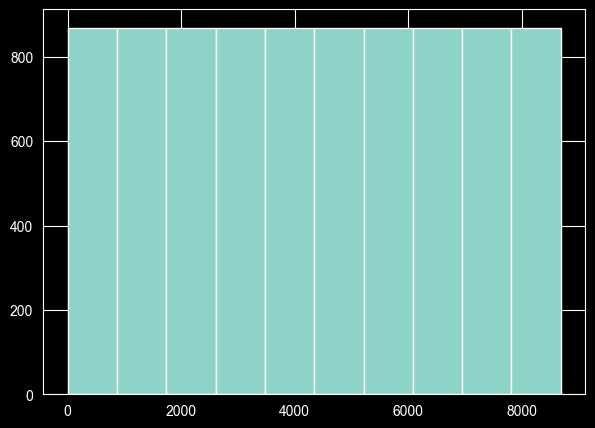

<AxesSubplot:>

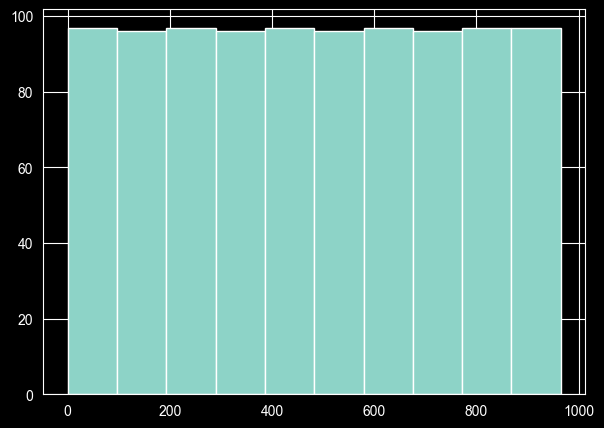

In [76]:
#проверим действительно ли столбец 'Unnamed: 0' это просто нумерация строк по порядку
display(X_train['Unnamed: 0'].describe())
display(X_test['Unnamed: 0'].describe())
display(X_train['Unnamed: 0'].hist())
plt.show()
display(X_test['Unnamed: 0'].hist())
plt.show()

In [77]:
# Сохранем медианные значения которыми заполним пропуски в отдельный файл
# копия train
df = X_train.copy()

# приведение имён колонок
df.columns = [c.lower().replace(" ", "_") for c in df.columns]

# считаем медианы
stats = {
    "stress_level_median": float(pd.to_numeric(df["stress_level"], errors="coerce").median()),
    "physical_activity_median": float(pd.to_numeric(df["physical_activity_days_per_week"], errors="coerce").median()),
    "sleep_hours_median": float(pd.to_numeric(df["sleep_hours_per_day"], errors="coerce").median()),
    "binary_fill_value": -1
}

# защита от NaN
for k, v in stats.items():
    if pd.isna(v):
        stats[k] = 0

# сохраняем
# текущая папка (где запущен ноутбук, обычно .../heart_attack_project/notebooks)
current_dir = Path.cwd()

# корень проекта = на уровень выше notebooks
project_root = current_dir.parent

# папка models в корне проекта
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

# путь к файлу с медианами
stats_path = models_dir / "preprocess_stats.json"

# сохраняем
with open(stats_path, "w", encoding="utf-8") as f:
    json.dump(stats, f, indent=2, ensure_ascii=False)

print(f"Saved preprocess stats to: {stats_path}")

stats


Saved preprocess stats to: C:\Users\taran\heart_attack_project\models\preprocess_stats.json


{'stress_level_median': 5.0,
 'physical_activity_median': 3.0,
 'sleep_hours_median': 0.4999999999999999,
 'binary_fill_value': -1}

## Предобработка данных

In [78]:
#удалим ненужный столбец с порядковой нумерацией
X_train=X_train.drop('Unnamed: 0',axis=1)
X_test=X_test.drop('Unnamed: 0',axis=1)

In [79]:
#переименуем столбцы
for i in X_train.columns.tolist():
    X_train.rename(columns={i:i.lower().replace(' ', '_')},inplace=True)
print(X_train.columns.tolist())

for j in X_test.columns.tolist():
    X_test.rename(columns={j:j.lower().replace(' ', '_')},inplace=True)
print(X_test.columns.tolist())

['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'heart_attack_risk_(binary)', 'blood_sugar', 'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'id']
['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'blood_sugar', 'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'id']


Для обработки пропусков сделаем следующее:
1. проверим являются ли пропуски систематическими, или имеют рандомный характер
2. выберем стратегию заполнения в зависимости от характера пропусков в данных.
Из предварительного анализа данных известно, что в тестовой и тренировочной выборках имеются пропуски в одних и тех же столбцах, проверим встречаются ли эти пропуски в одних и тех же строках, или нет, определим систематические они, или нет.

In [80]:
#Проверим тренировочную выборку на строки с пропусками
X_train.query(
    'diabetes.isna() & '
    'family_history.isna() & '
    'smoking.isna() & '
    'obesity.isna() & '
    'alcohol_consumption.isna() & '
    'previous_heart_problems.isna() & '
    'medication_use.isna() & '
    'stress_level.isna() & '
    'physical_activity_days_per_week.isna()'
).shape

(243, 27)

In [81]:
#Проверим тестовую выборку на строки с пропусками
X_test.query(
    'diabetes.isna() & '
    'family_history.isna() & '
    'smoking.isna() & '
    'obesity.isna() & '
    'alcohol_consumption.isna() & '
    'previous_heart_problems.isna() & '
    'medication_use.isna() & '
    'stress_level.isna() & '
    'physical_activity_days_per_week.isna()'
).shape

(31, 26)

По полученным результатам видно, что не заполнены пациентами блоки данных, т.е. разные пациенты не заполнили информацию в одних и тех же столбцах. Эти пропуски систематические и их довольно много: если строки с пропусками удалить, можно потерять данные 243 пациентов в тренировочных данных. Поэтому для категриальных переменных пропуски заполним значением -1, для числовых данных - медианой.

In [82]:
#заполни пропуски -1 и медианой, где необходимо

binary_cols = ['diabetes', 'family_history', 'smoking', 'obesity', 
               'alcohol_consumption', 'previous_heart_problems', 'medication_use']

X_train['stress_level']=X_train['stress_level'].fillna(X_train['stress_level'].median())
X_test['stress_level']=X_test['stress_level'].fillna(X_train['stress_level'].median())
X_train['physical_activity_days_per_week']=X_train['physical_activity_days_per_week'].fillna(X_train['physical_activity_days_per_week'].median())
X_test['physical_activity_days_per_week']=X_test['physical_activity_days_per_week'].fillna(X_test['physical_activity_days_per_week'].median())
X_train[binary_cols] = X_train[binary_cols].fillna(-1)
X_test[binary_cols] = X_test[binary_cols].fillna(-1)
print(X_train.isna().sum())
print(X_test.isna().sum())

age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
heart_attack_risk_(binary)         0
blood_sugar                        0
ck-mb                              0
troponin                           0
gender                             0
systolic_blood_pressure            0
diastolic_blood_pressure           0
id                                 0
d

In [83]:
# Проверим данные на наличие явных полных дубликатов
print(X_train.duplicated().sum())
print(X_test.duplicated().sum())
# Проверим данные на наличие явных дубликатов в столбце id
print(X_train['id'].duplicated().sum())
print(X_test['id'].duplicated().sum())

0
0
0
0


In [84]:
# проверим данные на наличие неявных дубликатов в столбце gender
print(X_train['gender'].unique())
print(X_test['gender'].unique())

['Male' 'Female' '1.0' '0.0']
['Male' 'Female' '1.0' '0.0']


Данные в столбце gender заполнены неверно, именно у тех пациентов, которые не заполнили полностью анкеты. Так как данные для этих пациентов неполные, и пол обозначен неккоректно, то заменим значения gender 1.0 и 0.0 на unknown. 

In [85]:
# заменяем аномальные значения, приводим строковые данные в нижний регистр
X_train['gender'] = X_train['gender'].astype(str).str.lower()
X_train['gender'] = X_train['gender'].replace(['1.0', '0.0'], 'unknown')
X_test['gender'] = X_test['gender'].astype(str).str.lower()
X_test['gender'] = X_test['gender'].replace(['1.0', '0.0'], 'unknown')
# проверяем результаты обработки
print(X_train['gender'].unique())
print(X_test['gender'].unique())

['male' 'female' 'unknown']
['male' 'female' 'unknown']


In [86]:
# Проверим столбец diet
print(X_train['diet'].unique())
print(X_test['diet'].unique())

[1 2 0 3]
[2 0 1 3]


In [87]:
# Изменим тип данных в столбце physical_activity_days_per_week
X_train['physical_activity_days_per_week']=X_train['physical_activity_days_per_week'].astype('int')
X_test['physical_activity_days_per_week']=X_test['physical_activity_days_per_week'].astype('int')
print(X_train['physical_activity_days_per_week'].unique())
print(X_test['physical_activity_days_per_week'].unique())

[3 2 0 5 6 4 7 1]
[1 0 7 5 3 2 4 6]


In [88]:
# Изменим тип данных в столбце stress_level
X_test['stress_level']=X_test['stress_level'].astype('int')
X_train['stress_level']=X_train['stress_level'].astype('int')
print(X_train['stress_level'].unique())
print(X_test['stress_level'].unique())

[ 8  9  6  3  7  1 10  5  2  4]
[ 8  5 10  7  1  4  9  6  3  2]


In [89]:
for data in binary_cols:
    X_train[data]=X_train[data].astype('int')
    print(X_train[data].unique())

[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
[ 0  1 -1]


In [90]:
X_train['heart_attack_risk_(binary)']=X_train['heart_attack_risk_(binary)'].astype('int')
print(X_train['heart_attack_risk_(binary)'].unique())

[0 1]


In [91]:
#округлим значения категориального признака sleep_hours_per_day
X_train['sleep_hours_per_day'] = (
    X_train['sleep_hours_per_day']
    .round(6)
    .astype('int')
)

X_test['sleep_hours_per_day'] = (
    X_test['sleep_hours_per_day']
    .round(6)
    .astype('int')
)
X_train['sleep_hours_per_day'].unique()
X_test['sleep_hours_per_day'].unique()

array([0, 1])

In [92]:
X_train.nunique()

age                                  77
cholesterol                         282
heart_rate                           87
diabetes                              3
family_history                        3
smoking                               3
obesity                               3
alcohol_consumption                   3
exercise_hours_per_week            7933
diet                                  4
previous_heart_problems               3
medication_use                        3
stress_level                         10
sedentary_hours_per_day            7933
income                             7808
bmi                                7933
triglycerides                       772
physical_activity_days_per_week       8
sleep_hours_per_day                   2
heart_attack_risk_(binary)            2
blood_sugar                         239
ck-mb                               679
troponin                            340
gender                                3
systolic_blood_pressure             100


In [93]:
X_train.head()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,...,3,0,0,0.227018,0.048229,0.036512,male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,...,3,0,0,0.150198,0.017616,0.000194,female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,...,2,1,0,0.227018,0.048229,0.036512,female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,...,0,0,1,0.227018,0.048229,0.036512,female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,...,5,1,1,0.227018,0.048229,0.036512,male,0.619355,0.441860,4047


### Выводы по предобработке данных
По результатам предобработки:
1. Удален служебный столбец, не содержащий важной информации 'Unnamed: 0'.
2. Переименованы все столбцы, названия приведены к единому формату.
3. Обработаны пропуски, заполнены -1 или медианой.
4. Явные дубликаты в данных не обнаружены.
5. Обнаружены аномальные значения в столбце gender у пациентов, которые не до конца заполнили анкетные данные, аномальные значения заменены на 'unknown'.
6. категориальные данные преобразованы к целочисленному типу.

## Исследовательский анализ данных

In [94]:
#Исследуем числовые данные
# Функция для построения гистограмм и боксплотов для численных данных
def numerical_visualise_histbox(dataset,column,bins,value):
    display(dataset[column].describe())
    dataset[column].sort_values(ascending=False).plot(kind='hist', bins=bins, edgecolor='black', range=(min(dataset[column]),max(dataset[column])), grid=True)
    plt.title(f"Распределение признака: {column}", fontsize=15, fontweight="bold")
    plt.xlabel(f'Знач. признака, {value}')# добавлена единица измерения
    plt.ylabel('Количество наблюдений')
    plt.ticklabel_format(axis='x', style='plain')
    
    if dataset[column].dtype in ['int64', 'int32']:
        plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    else:
        plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
        
    plt.show()
    
    dataset[column].plot.box()
    plt.ylabel(f'Знач. признака, {value}')
    plt.tight_layout()
    plt.show()

In [95]:
#Функции для построения барплота (количество для кат. признаков)
def barh_plot(data, column_1, column_2, value_1,value_2):
    print(data[column_1].describe())
    grouped_data = data.groupby(column_1)[column_2].count().sort_values()
    
    # Создаем график
    ax = grouped_data.plot(
        kind='barh', 
        color=['g'], 
        linestyle='--'
    )
    
    plt.title(f"Распределение признака: {column_1}", fontsize=15, fontweight="bold")
    plt.xlabel( value_1, fontsize=10, fontweight="bold")
    plt.ylabel(f'Знач. признака: {column_1} {value_2}', fontsize=10, fontweight="bold")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.ticklabel_format(axis='x', style='plain')
    
    # Добавляем подписи для каждого столбика
    for i, v in enumerate(grouped_data):
        ax.text(v + 0.01, i, str(v), va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    

In [96]:
list_for_hist=['age',
               'cholesterol', 
               'heart_rate',
               'diabetes',
               'family_history',
               'smoking',
               'obesity',
               'alcohol_consumption',
               'exercise_hours_per_week',
               'diet',
               'previous_heart_problems',
               'medication_use','stress_level',
               'sedentary_hours_per_day'
               'income','bmi',
               'triglycerides',
               'physical_activity_days_per_week',
               'sleep_hours_per_day',
               'heart_attack_risk_(binary)',
               'blood_sugar',
               'ck-mb',
               'troponin',
               'gender',
               'systolic_blood_pressure',
               'diastolic_blood_pressure'
              ]
list_for_barh=[]

train


count    8685.000000
mean        0.449958
std         0.231174
min         0.000000
25%         0.258427
50%         0.460674
75%         0.640449
max         1.000000
Name: age, dtype: float64

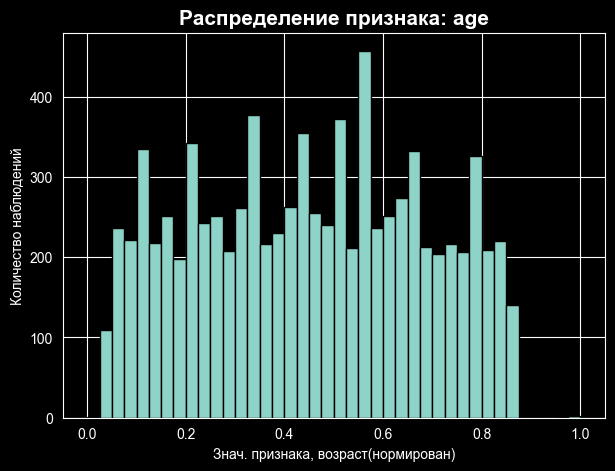

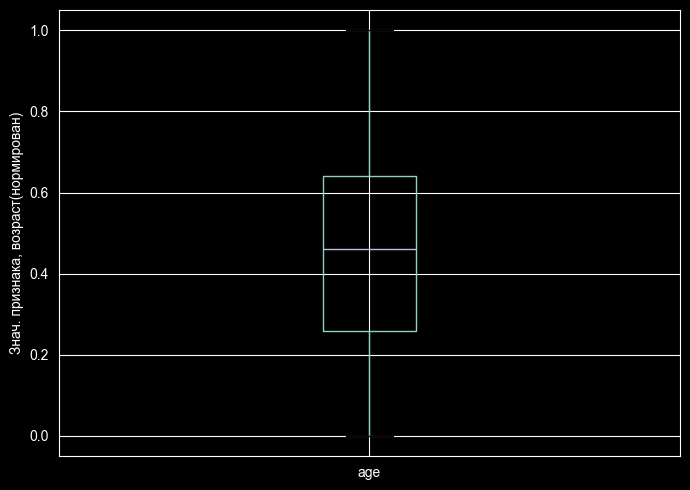

test


count    966.000000
mean       0.452916
std        0.231068
min        0.044944
25%        0.247191
50%        0.460674
75%        0.640449
max        0.853933
Name: age, dtype: float64

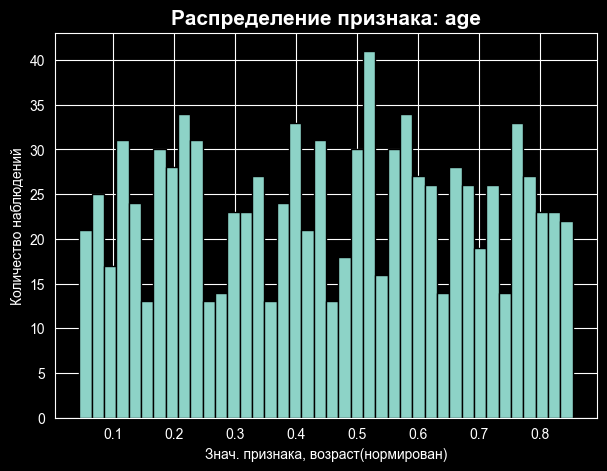

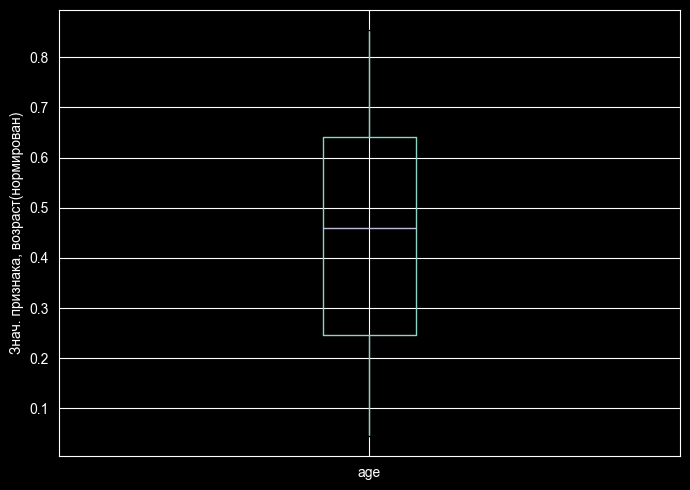

In [97]:
print('train')
numerical_visualise_histbox(X_train,'age',40,'возраст(нормирован)')
print('test')
numerical_visualise_histbox(X_test,'age',40,'возраст(нормирован)')
plt.show()

In [98]:
X_train.query('cholesterol>=0.499780 & cholesterol<=0.49979')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
16,0.449438,0.49978,0.063245,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.233202,0.026692,0.000777,unknown,0.393548,0.255814,9528
90,0.370787,0.49978,0.066911,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.154150,0.004702,0.042043,unknown,0.258065,0.337209,9640
92,0.629213,0.49978,0.073327,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.256917,0.012310,0.000777,unknown,0.258065,0.232558,9515
185,0.516854,0.49978,0.045830,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.559289,0.006704,0.000291,unknown,0.174194,0.151163,9491
188,0.269663,0.49978,0.035747,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.112648,0.051218,0.000485,unknown,0.225806,0.162791,9448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,0.719101,0.49978,0.049496,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.138340,0.004034,0.003204,unknown,0.548387,0.558140,9455
8509,0.651685,0.49978,0.036664,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.239130,0.055790,0.060783,unknown,0.729032,0.779070,9506
8536,0.651685,0.49978,0.054079,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.276680,0.008673,0.150403,unknown,0.606452,0.790698,9474
8619,0.606742,0.49978,0.059578,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.156126,0.057692,0.000583,unknown,0.387097,0.500000,9467


Тот же проблемный блок, в котором не дозаполнены анкетные данные пациентами, у этих пациентов уровень холестирина заполнен медианным значением, что видно на графике ниже. “Часть датасета содержит шаблонные записи с идентичными признаками и классом 0, что ограничивает предсказуемость модели.” Удалим эти записи.

train


count    8685.000000
mean        0.501070
std         0.284716
min         0.000000
25%         0.267857
50%         0.499780
75%         0.746429
max         1.000000
Name: cholesterol, dtype: float64

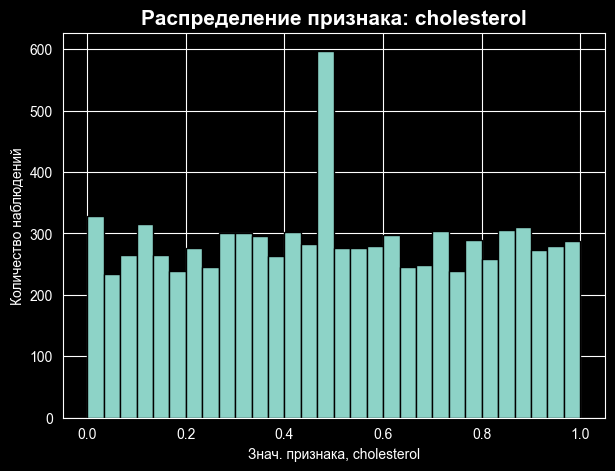

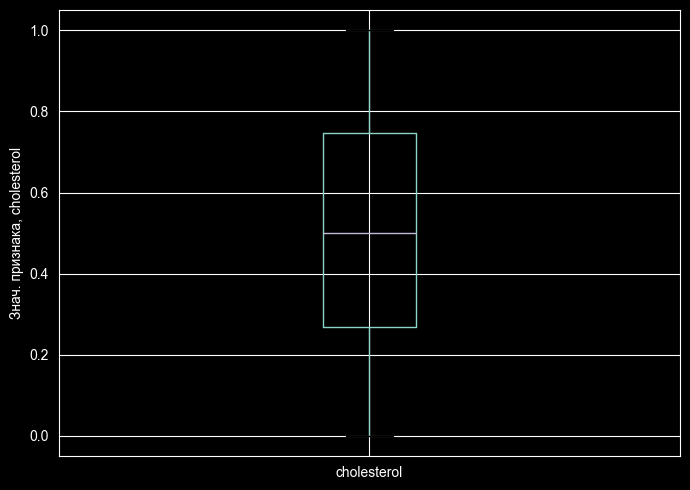

test


count    966.000000
mean       0.488181
std        0.282039
min        0.000000
25%        0.243750
50%        0.499780
75%        0.710714
max        0.996429
Name: cholesterol, dtype: float64

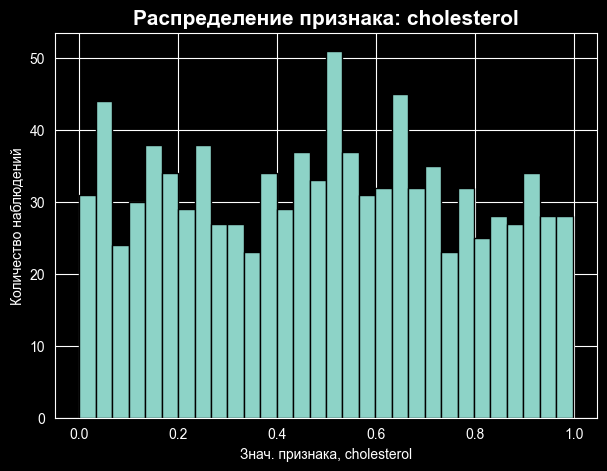

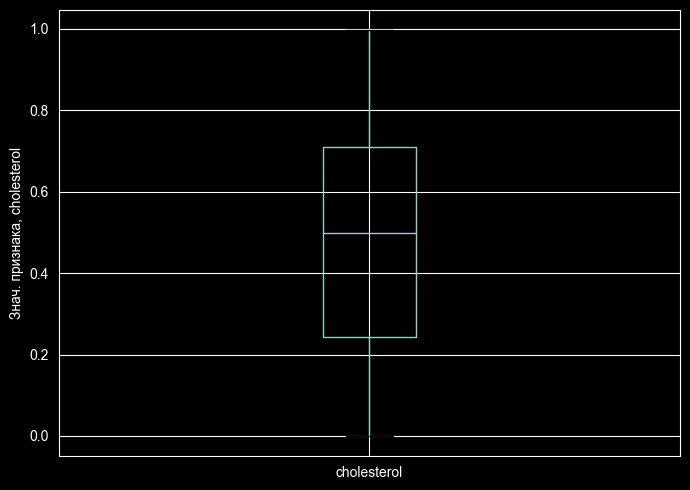

In [99]:
print('train')
numerical_visualise_histbox(X_train,'cholesterol',30,'cholesterol')
print('test')
numerical_visualise_histbox(X_test,'cholesterol',30,'cholesterol')
plt.show()

train


count    8685.000000
mean        0.050658
std         0.023453
min         0.000000
25%         0.034830
50%         0.050412
75%         0.065995
max         1.000000
Name: heart_rate, dtype: float64

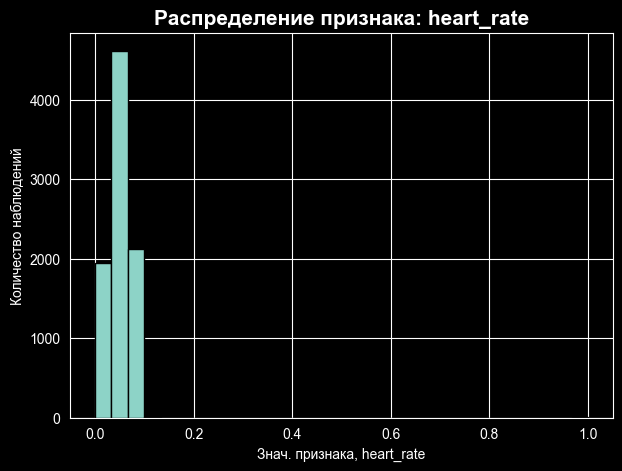

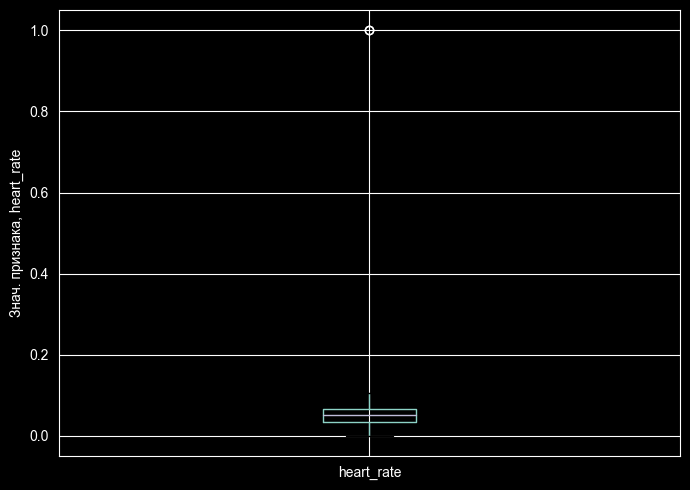

test


count    966.000000
mean       0.051644
std        0.035502
min        0.000000
25%        0.036664
50%        0.050412
75%        0.065995
max        1.000000
Name: heart_rate, dtype: float64

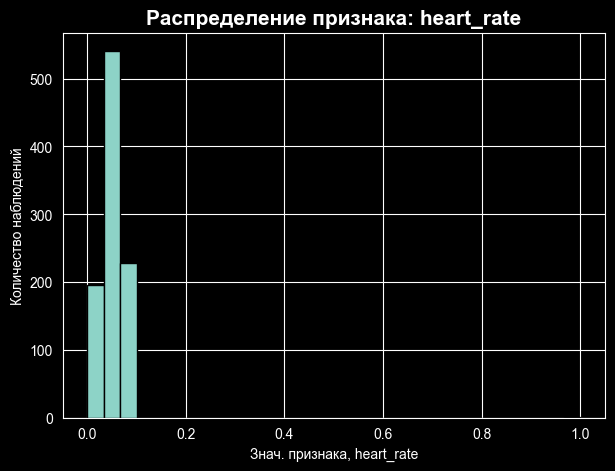

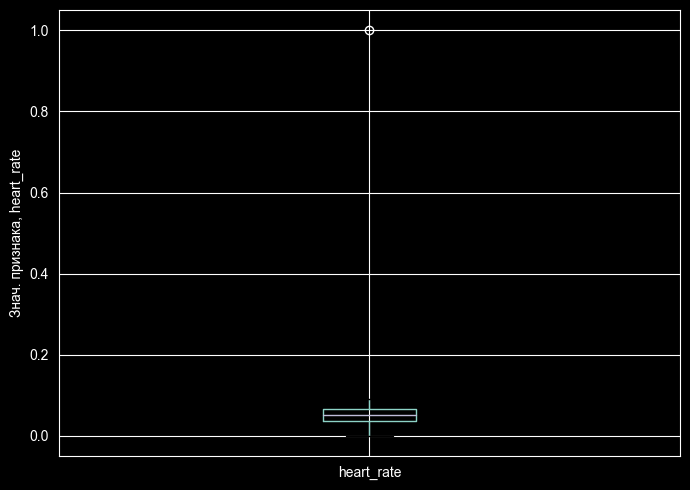

In [100]:
print('train')
numerical_visualise_histbox(X_train,'heart_rate',30,'heart_rate')
print('test')
numerical_visualise_histbox(X_test,'heart_rate',30,'heart_rate')
plt.show()

In [101]:
# проанализируем выброс
X_train.query('heart_rate==1')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
1377,0.629213,0.49978,1.0,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.203557,0.011843,0.002622,unknown,0.490323,0.616279,9547
2712,0.202247,0.49978,1.0,-1,-1,-1,-1,-1,0.50211,3,...,3,0,0,0.092885,0.007805,0.000680,unknown,0.490323,0.616279,9611


In [102]:
# проанализируем выброс в test
X_test.query('heart_rate==1')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
456,0.348315,0.49978,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.50211,3,...,0.503603,3,0,0.146245,0.003367,0.097971,unknown,0.490323,0.616279,9394


С учетом того, что выброс - это всего лишь 2 в трен и 1 в тест записи о пациентах из числа тех, что не до конца заполнили анкету целесооразно удалитьэти две строки

In [103]:
X_train=X_train.query('heart_rate<1')
X_test=X_test.query('heart_rate<1')

train


count    8683.000000
mean        0.050439
std         0.018507
min         0.000000
25%         0.034830
50%         0.050412
75%         0.065995
max         0.105408
Name: heart_rate, dtype: float64

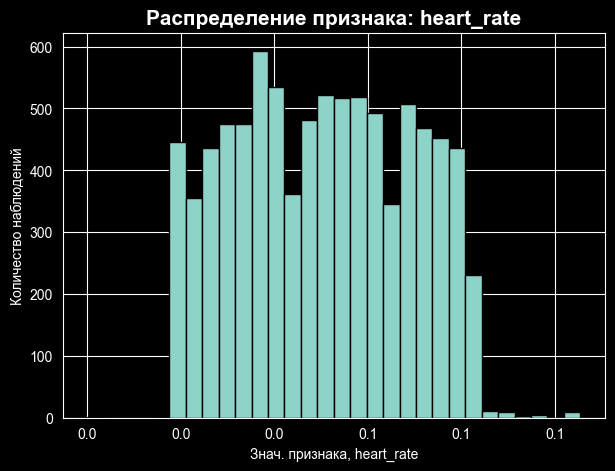

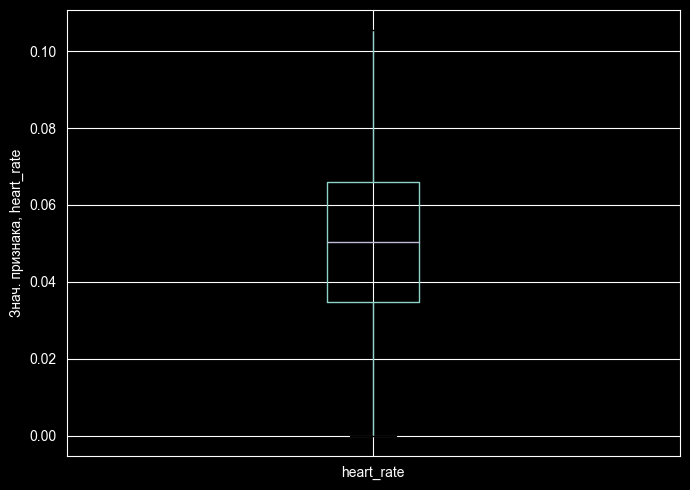

test


count    965.000000
mean       0.050661
std        0.018104
min        0.000000
25%        0.036664
50%        0.050412
75%        0.065995
max        0.090742
Name: heart_rate, dtype: float64

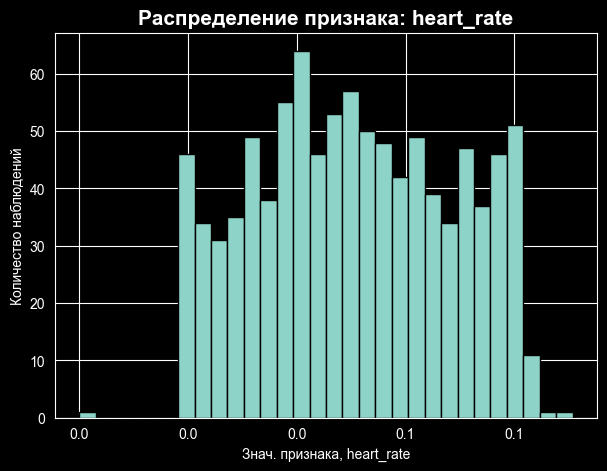

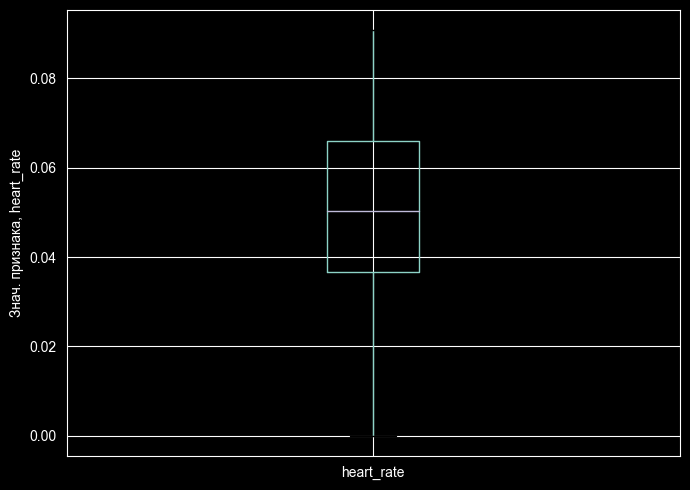

In [104]:
print('train')
numerical_visualise_histbox(X_train,'heart_rate',30,'heart_rate')
print('test')
numerical_visualise_histbox(X_test,'heart_rate',30,'heart_rate')
plt.show()

train
count    8683.000000
mean        0.606242
std         0.542455
min        -1.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: diabetes, dtype: float64


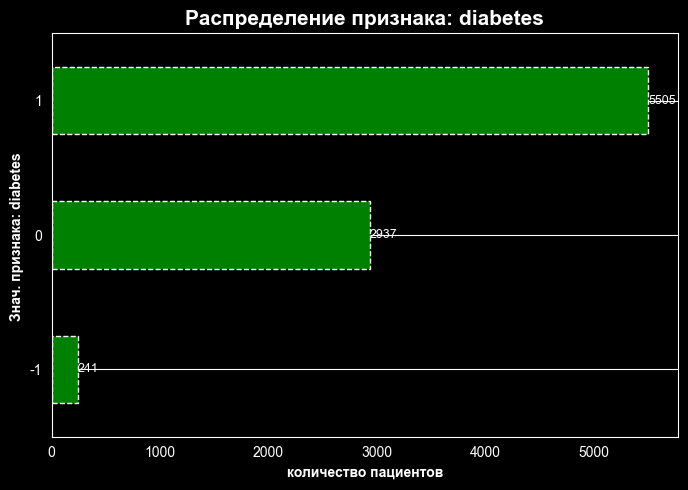

test
count    965.000000
mean       0.605181
std        0.549022
min       -1.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: diabetes, dtype: float64


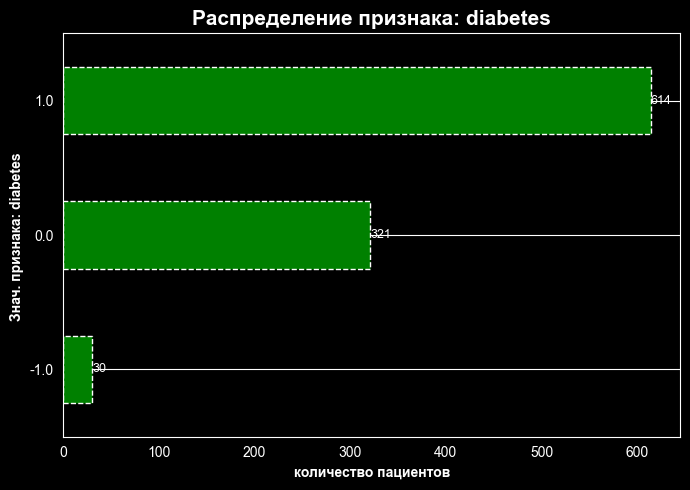

In [105]:
print('train')
barh_plot(X_train, 'diabetes', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'diabetes', 'id', 'количество пациентов','')
plt.show()

train
count    8683.000000
mean        0.448232
std         0.550332
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: family_history, dtype: float64


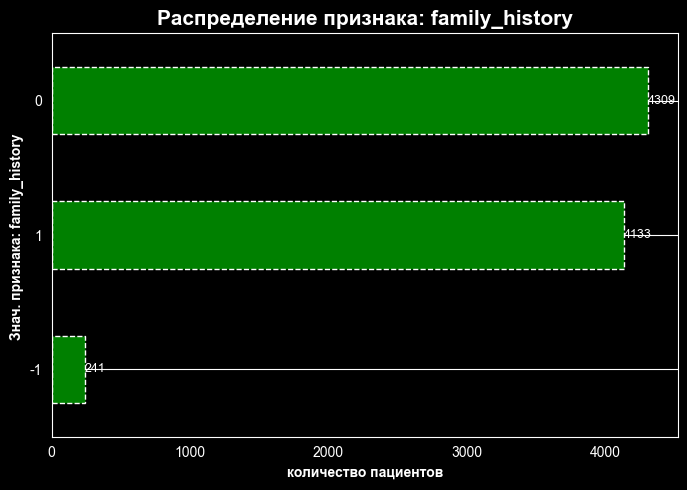

test
count    965.000000
mean       0.435233
std        0.555249
min       -1.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: family_history, dtype: float64


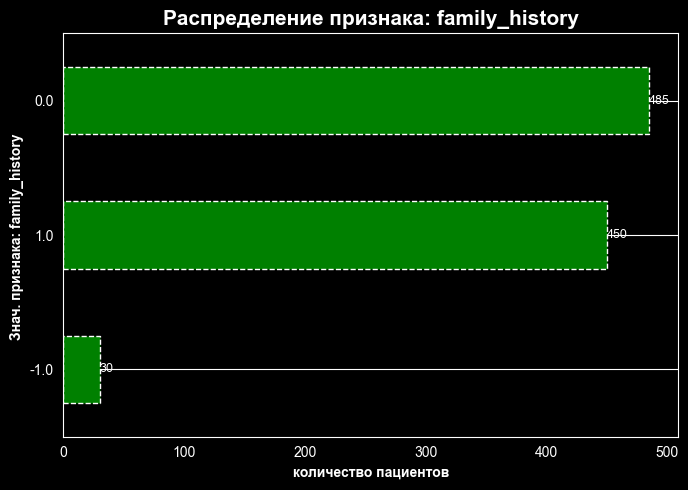

In [106]:
print('train')
barh_plot(X_train, 'family_history', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'family_history', 'id', 'количество пациентов','')
plt.show()

train
count    8683.000000
mean        0.850052
std         0.427780
min        -1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: smoking, dtype: float64


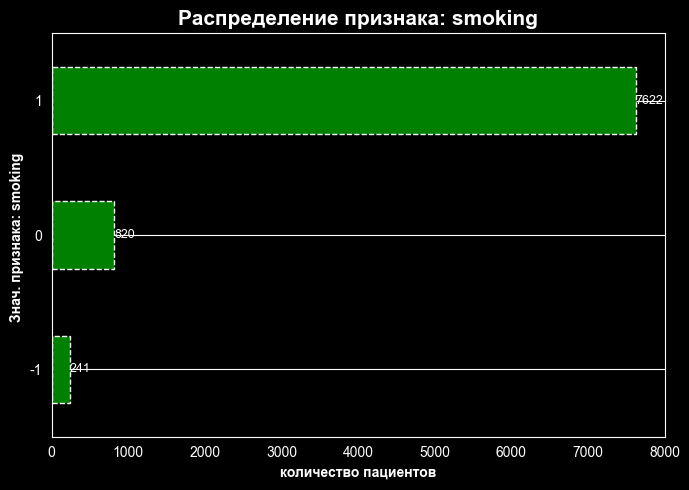

test
count    965.000000
mean       0.839378
std        0.444075
min       -1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: smoking, dtype: float64


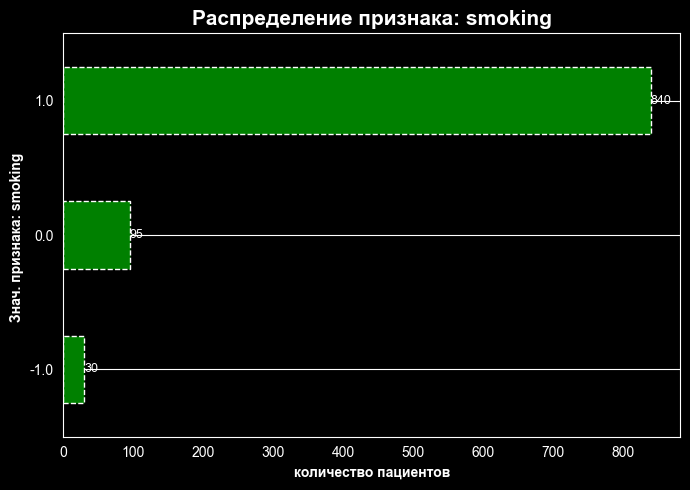

In [107]:
print('train')
barh_plot(X_train, 'smoking', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'smoking', 'id', 'количество пациентов','')
plt.show()

train
count    8683.000000
mean        0.456755
std         0.551068
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: obesity, dtype: float64


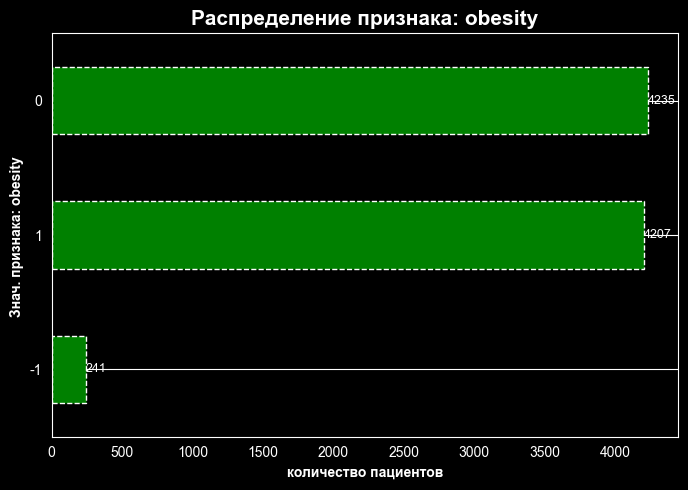

test
count    965.00000
mean       0.46943
std        0.55818
min       -1.00000
25%        0.00000
50%        1.00000
75%        1.00000
max        1.00000
Name: obesity, dtype: float64


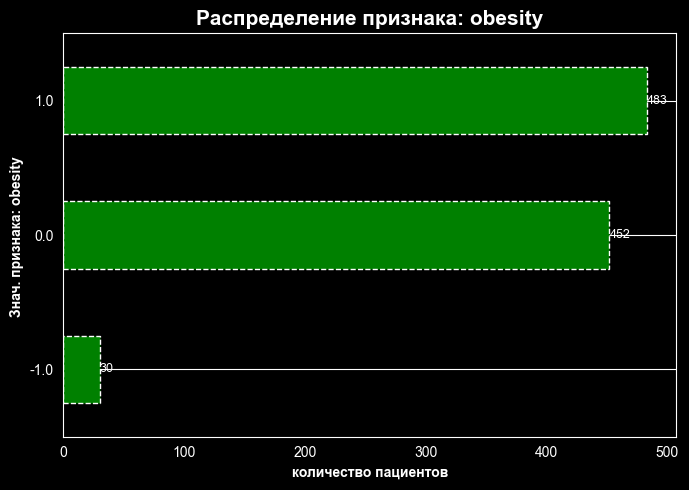

In [108]:
print('train')
barh_plot(X_train, 'obesity', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'obesity', 'id', 'количество пациентов','')
plt.show()

train
count    8683.000000
mean        0.557526
std         0.549760
min        -1.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: alcohol_consumption, dtype: float64


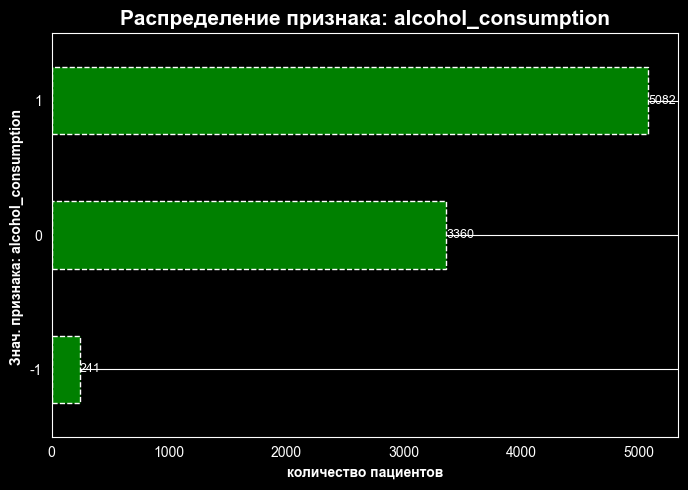

test
count    965.000000
mean       0.534715
std        0.557937
min       -1.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: alcohol_consumption, dtype: float64


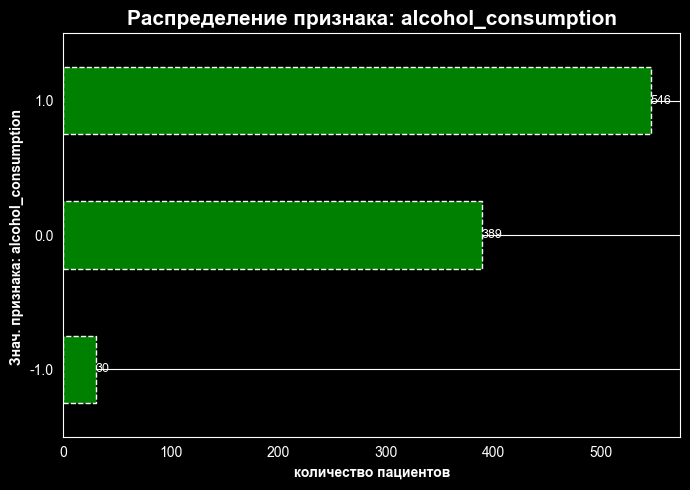

In [109]:
print('train')
barh_plot(X_train, 'alcohol_consumption', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'alcohol_consumption', 'id', 'количество пациентов','')
plt.show()

train


count    8683.000000
mean        0.503378
std         0.284843
min         0.000000
25%         0.263219
50%         0.502110
75%         0.748709
max         1.000000
Name: exercise_hours_per_week, dtype: float64

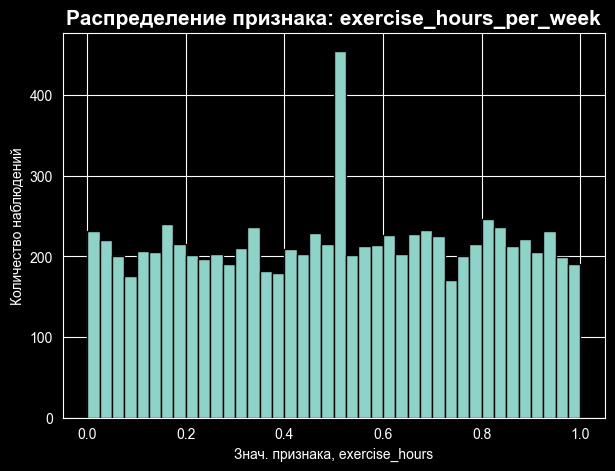

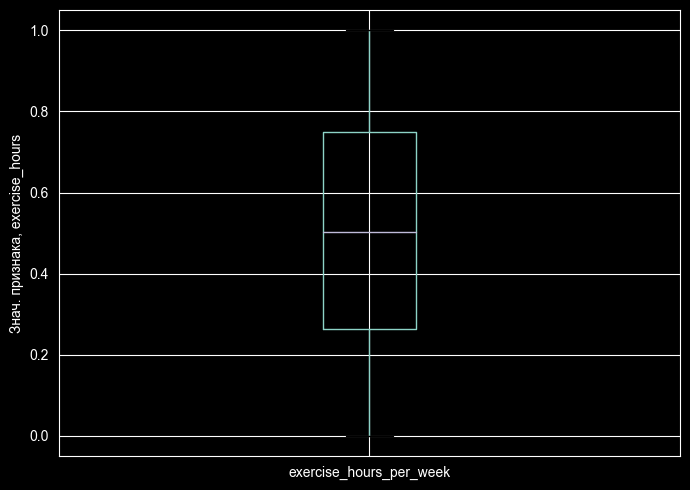

test


count    965.000000
mean       0.490694
std        0.285050
min        0.000336
25%        0.242591
50%        0.502110
75%        0.735130
max        0.998938
Name: exercise_hours_per_week, dtype: float64

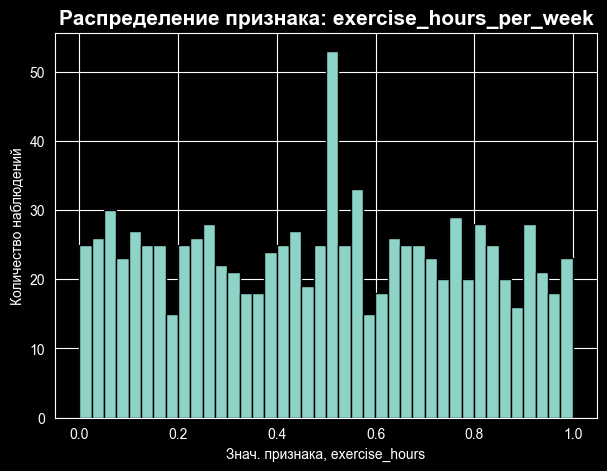

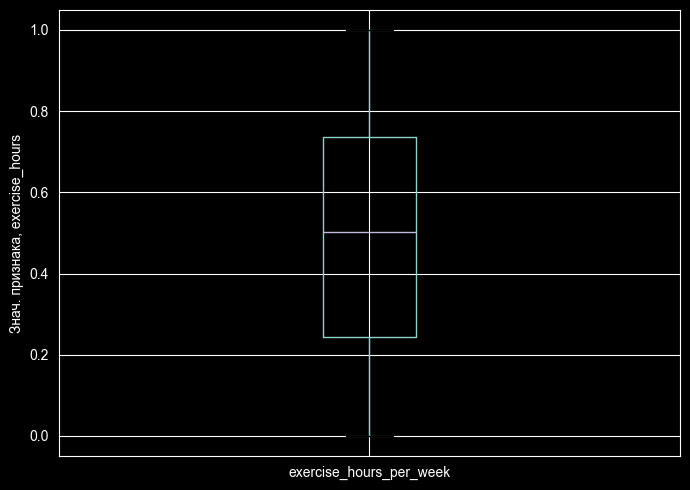

In [110]:
print('train')
numerical_visualise_histbox(X_train,'exercise_hours_per_week',40,'exercise_hours')
print('test')
numerical_visualise_histbox(X_test,'exercise_hours_per_week',40,'exercise_hours')
plt.show()

train
count    8683.000000
mean        1.057008
std         0.866244
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: diet, dtype: float64


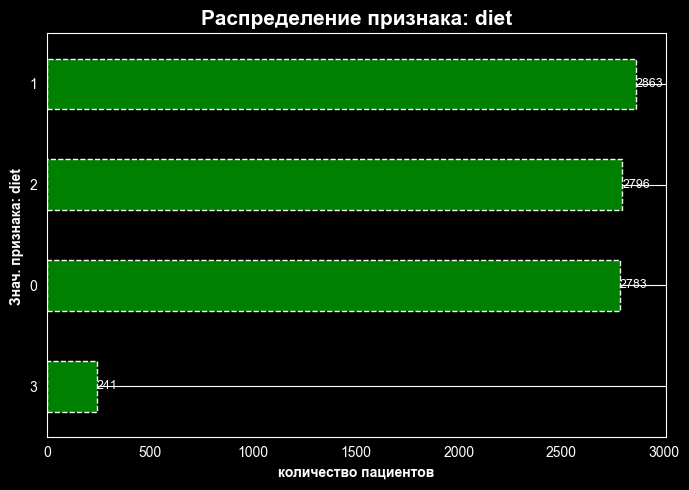

test
count    965.000000
mean       1.051813
std        0.882876
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: diet, dtype: float64


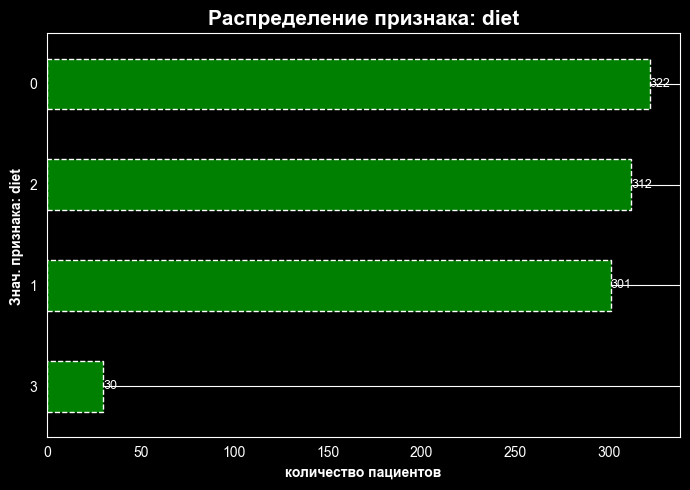

In [111]:
print('train')
barh_plot(X_train, 'diet', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'diet', 'id', 'количество пациентов','')
plt.show()

train
count    8683.000000
mean        0.453875
std         0.550834
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: previous_heart_problems, dtype: float64


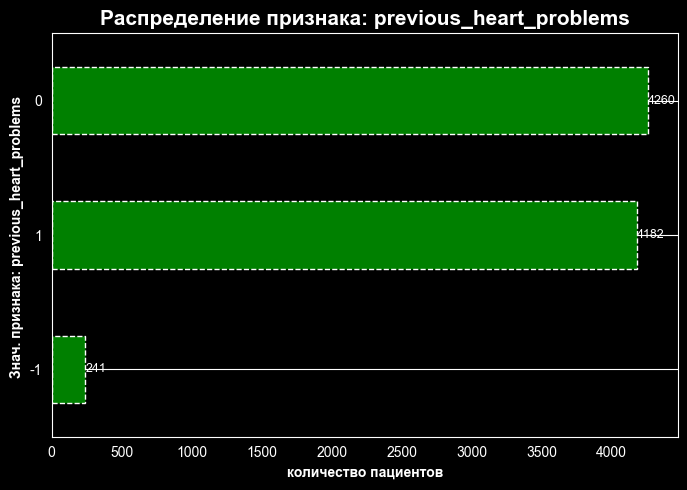

test
count    965.000000
mean       0.447668
std        0.556560
min       -1.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: previous_heart_problems, dtype: float64


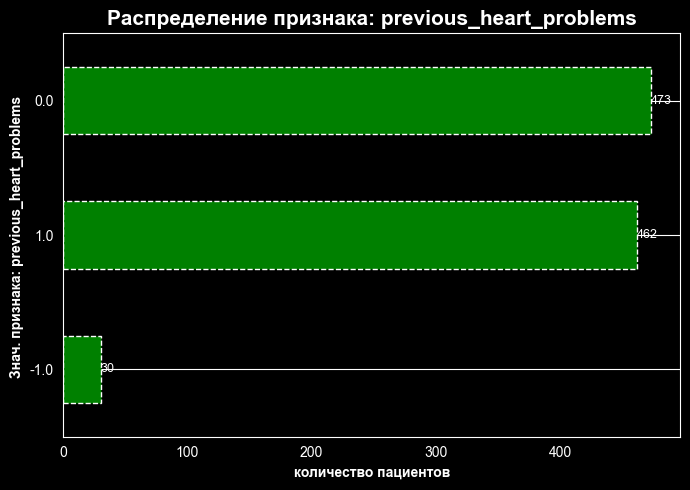

In [112]:
print('train')
barh_plot(X_train, 'previous_heart_problems', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'previous_heart_problems', 'id', 'количество пациентов','')
plt.show()

train
count    8683.000000
mean        0.459519
std         0.551278
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: medication_use, dtype: float64


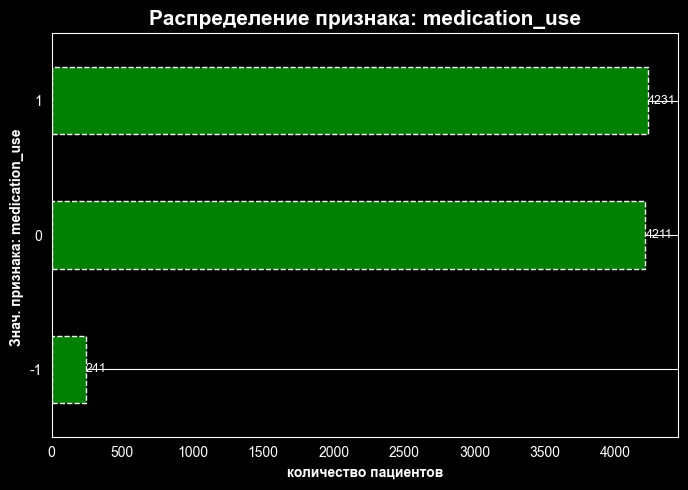

test
count    965.000000
mean       0.442487
std        0.556048
min       -1.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: medication_use, dtype: float64


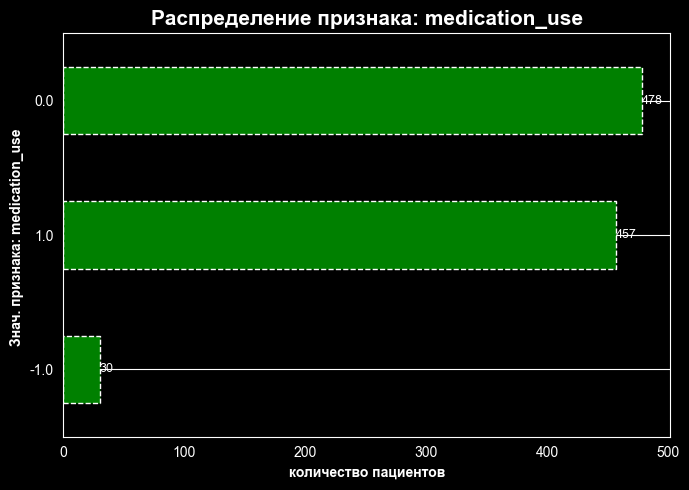

In [113]:
print('train')
barh_plot(X_train, 'medication_use', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'medication_use', 'id', 'количество пациентов','')
plt.show()

train
count    8683.000000
mean        5.479673
std         2.828939
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: stress_level, dtype: float64


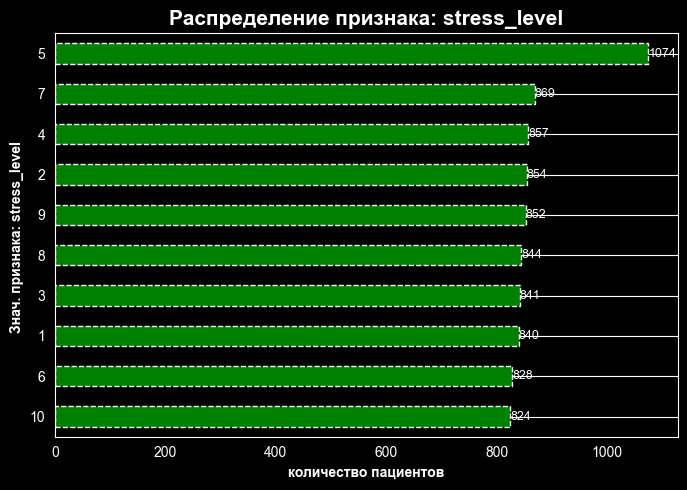

test
count    965.000000
mean       5.322280
std        2.814229
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: stress_level, dtype: float64


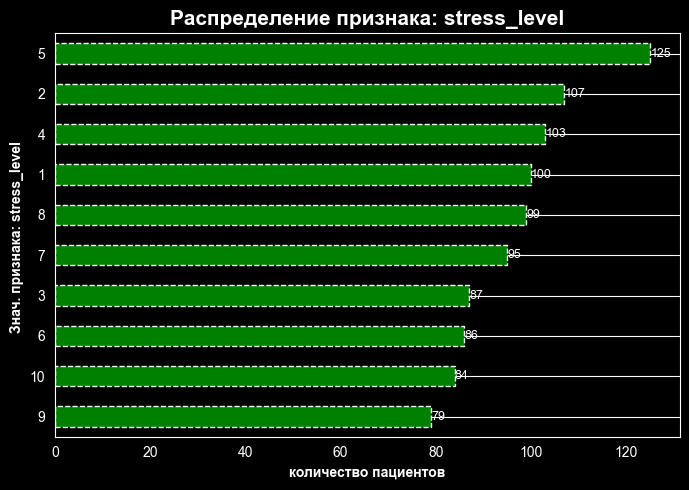

In [114]:
print('train')
barh_plot(X_train, 'stress_level', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'stress_level', 'id', 'количество пациентов','')
plt.show()

train


count    8683.000000
mean        0.499164
std         0.285373
min         0.000000
25%         0.255741
50%         0.499920
75%         0.744623
max         1.000000
Name: sedentary_hours_per_day, dtype: float64

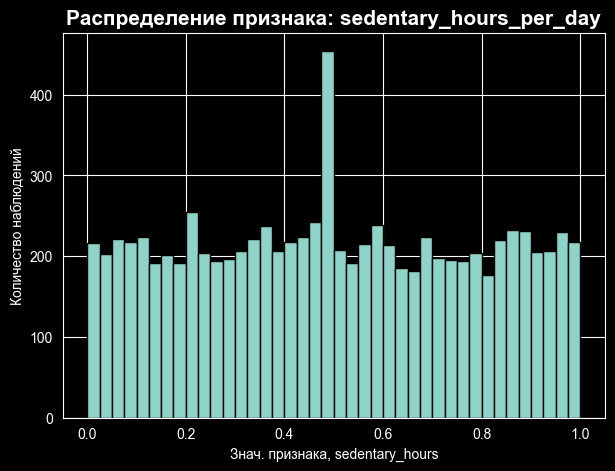

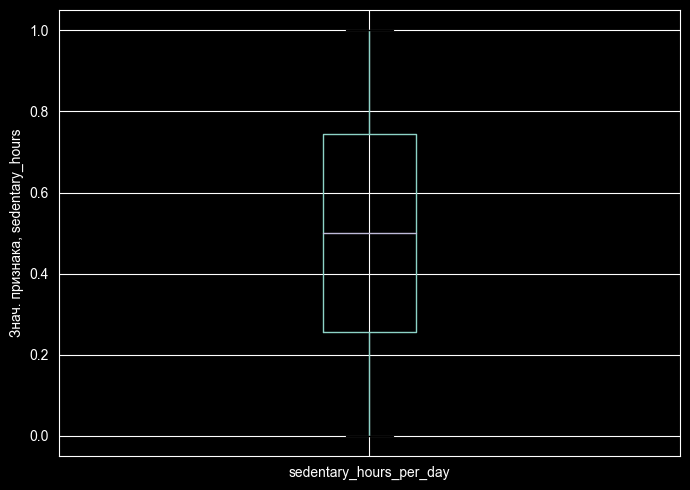

test


count    965.000000
mean       0.506722
std        0.287975
min        0.001187
25%        0.258609
50%        0.501486
75%        0.760046
max        0.999033
Name: sedentary_hours_per_day, dtype: float64

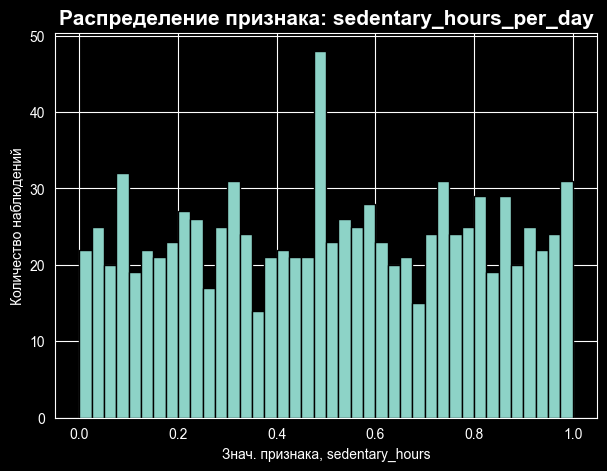

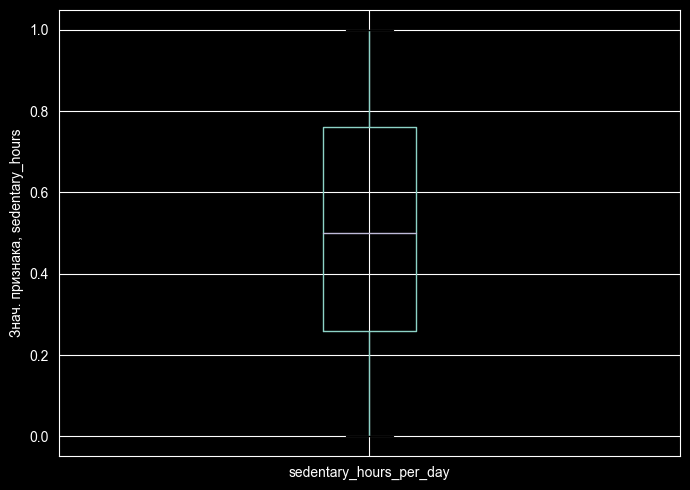

In [115]:
print('train')
numerical_visualise_histbox(X_train,'sedentary_hours_per_day',40,'sedentary_hours')
print('test')
numerical_visualise_histbox(X_test,'sedentary_hours_per_day',40,'sedentary_hours')
plt.show()

train


count    8683.000000
mean        0.496055
std         0.284731
min         0.000000
25%         0.251883
50%         0.494889
75%         0.741073
max         1.000000
Name: income, dtype: float64

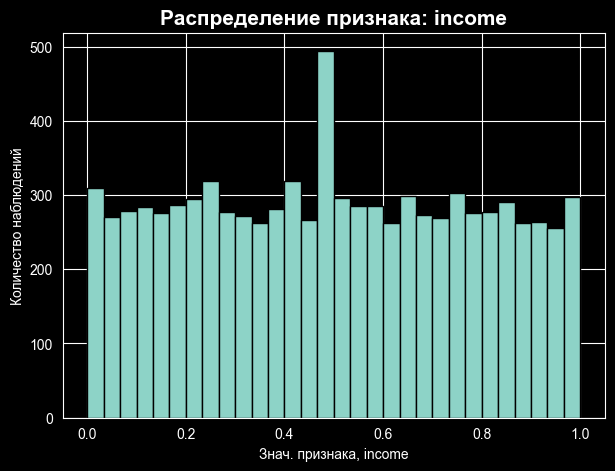

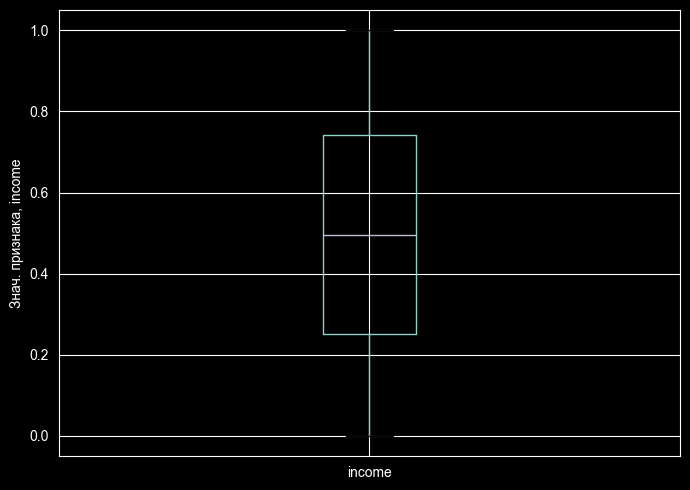

test


count    965.000000
mean       0.484397
std        0.274021
min        0.003351
25%        0.261426
50%        0.491683
75%        0.705547
max        0.998885
Name: income, dtype: float64

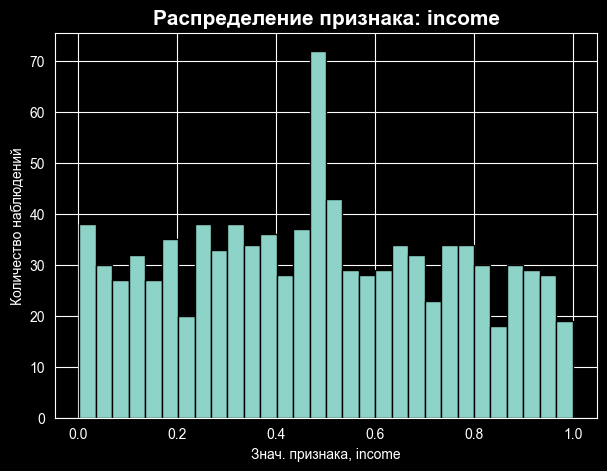

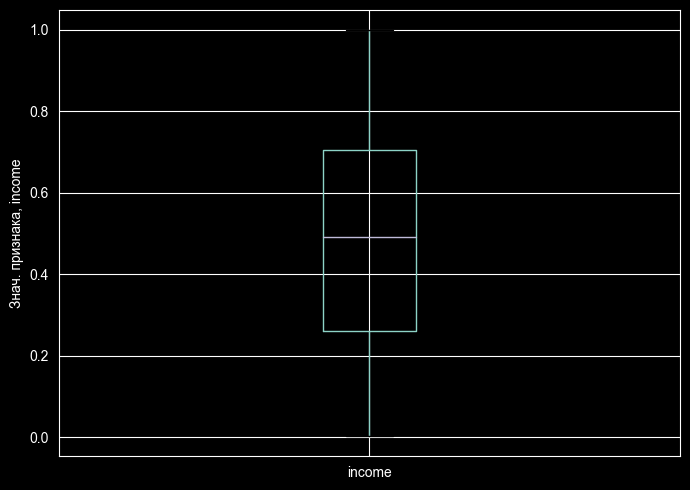

In [116]:
print('train')
numerical_visualise_histbox(X_train,'income',30,'income')
print('test')
numerical_visualise_histbox(X_test,'income',30,'income')
plt.show()

train


count    8683.000000
mean        0.496774
std         0.282594
min         0.000000
25%         0.254165
50%         0.494774
75%         0.737021
max         1.000000
Name: bmi, dtype: float64

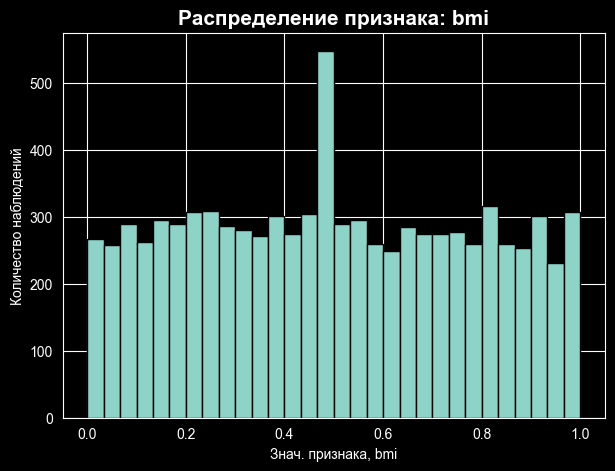

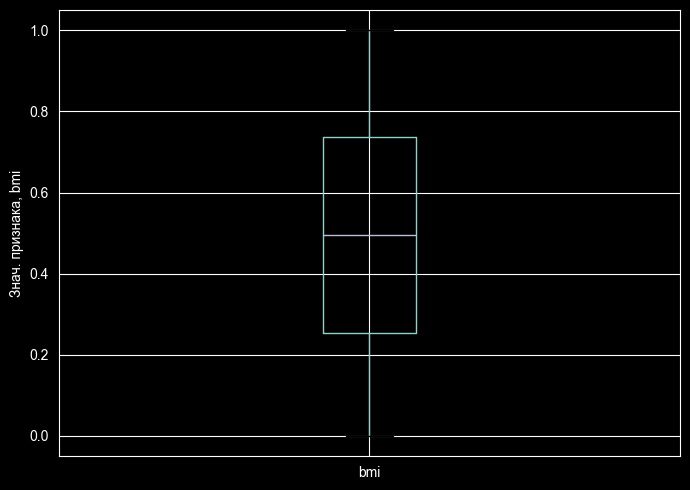

test


count    965.000000
mean       0.476777
std        0.292138
min        0.002598
25%        0.217265
50%        0.471112
75%        0.720769
max        0.999496
Name: bmi, dtype: float64

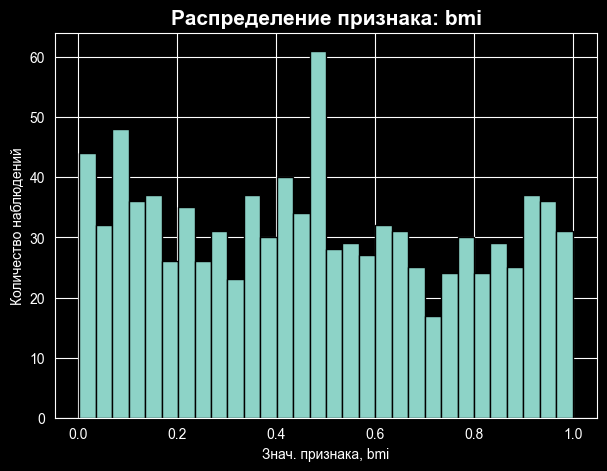

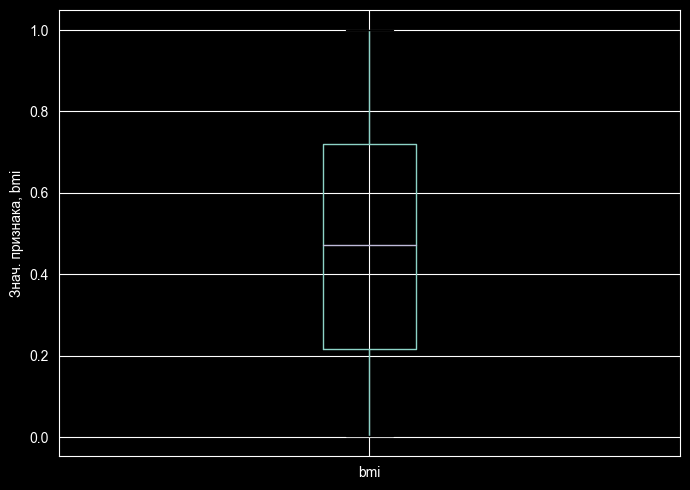

In [117]:
print('train')
numerical_visualise_histbox(X_train,'bmi',30,'bmi')
print('test')
numerical_visualise_histbox(X_test,'bmi',30,'bmi')
plt.show()

train


count    8683.000000
mean        0.505485
std         0.286353
min         0.000000
25%         0.263636
50%         0.503603
75%         0.750649
max         1.000000
Name: triglycerides, dtype: float64

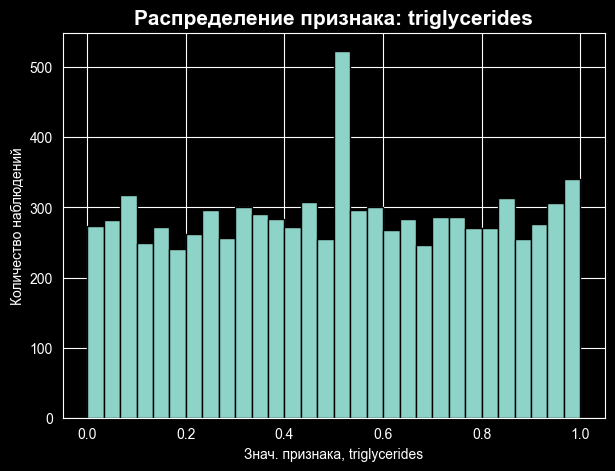

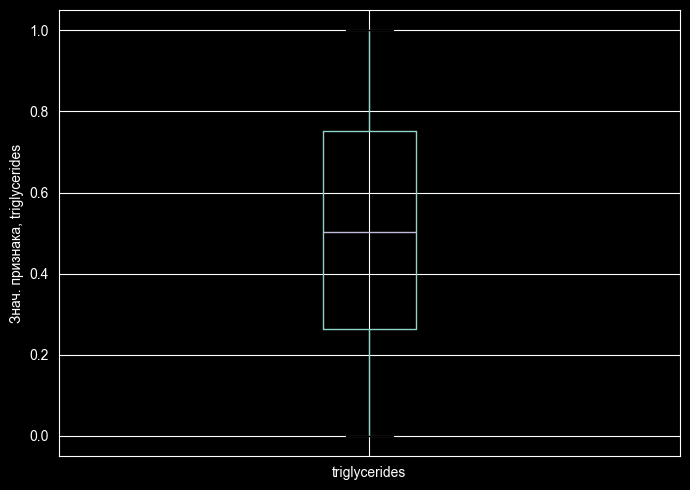

test


count    965.000000
mean       0.486670
std        0.284681
min        0.000000
25%        0.249351
50%        0.488312
75%        0.718182
max        0.998701
Name: triglycerides, dtype: float64

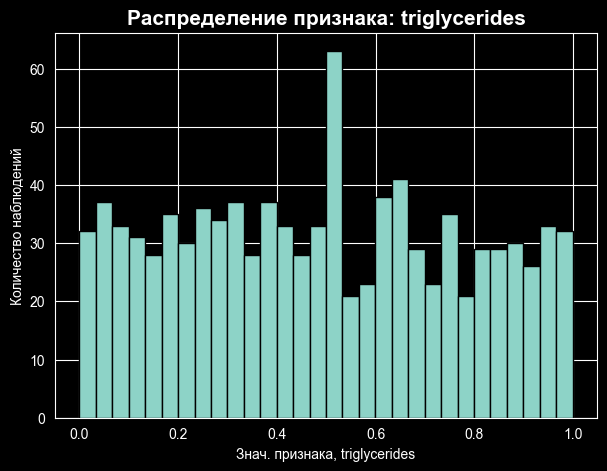

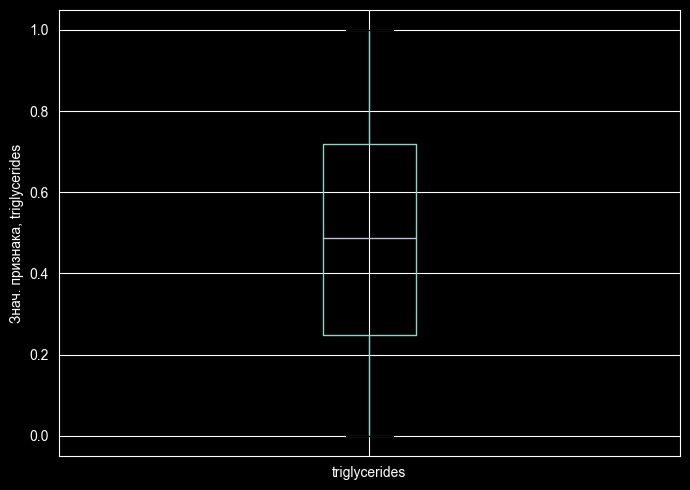

In [118]:
print('train')
numerical_visualise_histbox(X_train,'triglycerides',30,'triglycerides')
print('test')
numerical_visualise_histbox(X_test,'triglycerides',30,'triglycerides')
plt.show()

train
count    8683.000000
mean        3.494184
std         2.251429
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         7.000000
Name: physical_activity_days_per_week, dtype: float64


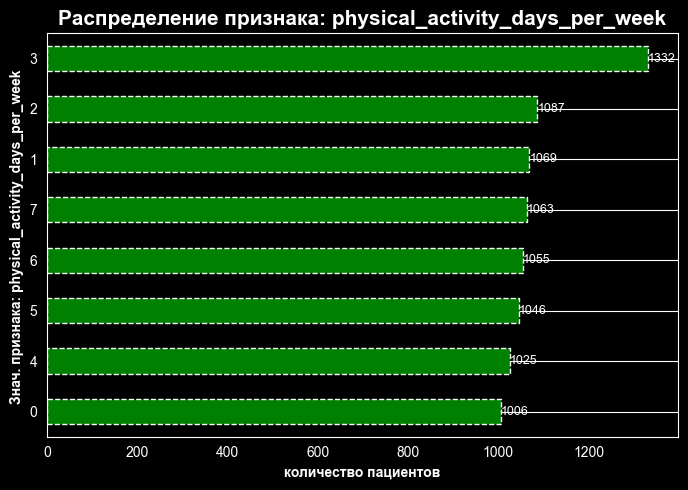

test
count    965.000000
mean       3.430052
std        2.267973
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max        7.000000
Name: physical_activity_days_per_week, dtype: float64


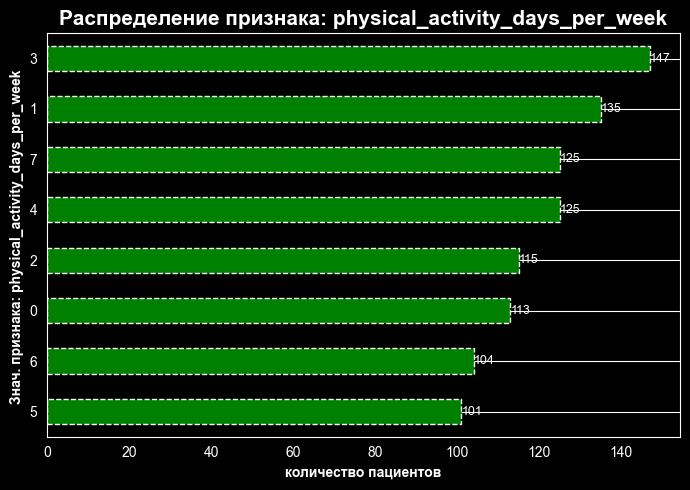

In [119]:
print('train')
barh_plot(X_train, 'physical_activity_days_per_week', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'physical_activity_days_per_week', 'id', 'количество пациентов','')
plt.show()

train
count    8683.000000
mean        0.145226
std         0.352349
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: sleep_hours_per_day, dtype: float64


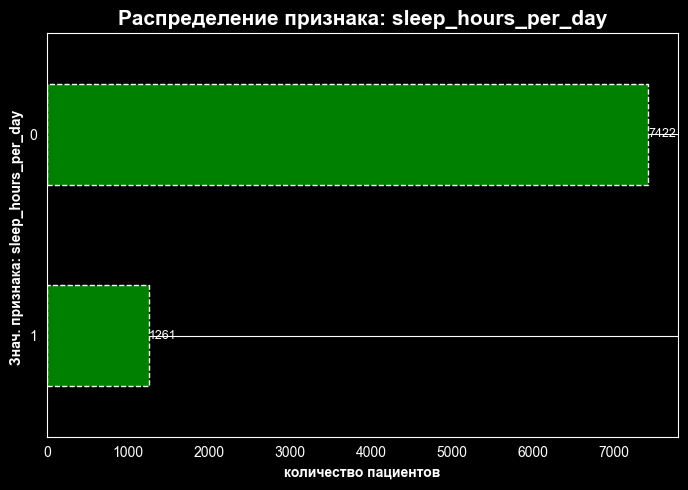

test
count    965.000000
mean       0.147150
std        0.354439
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: sleep_hours_per_day, dtype: float64


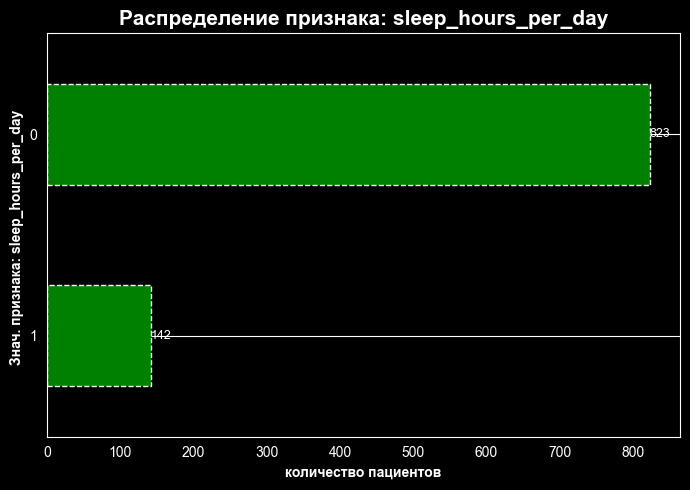

In [120]:
print('train')
barh_plot(X_train, 'sleep_hours_per_day', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'sleep_hours_per_day', 'id', 'количество пациентов','')
plt.show()

train


count    8683.000000
mean        0.227357
std         0.076630
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64

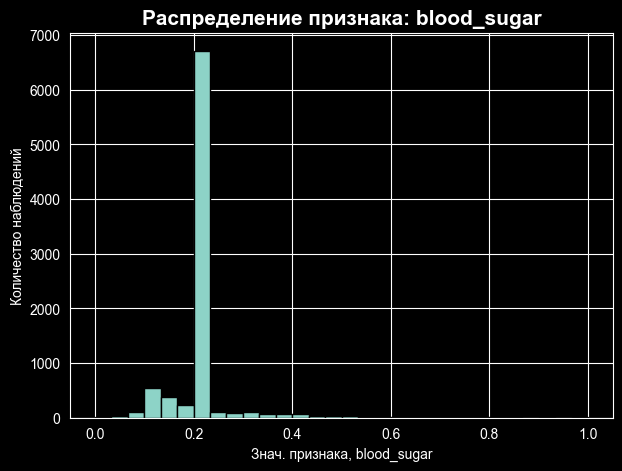

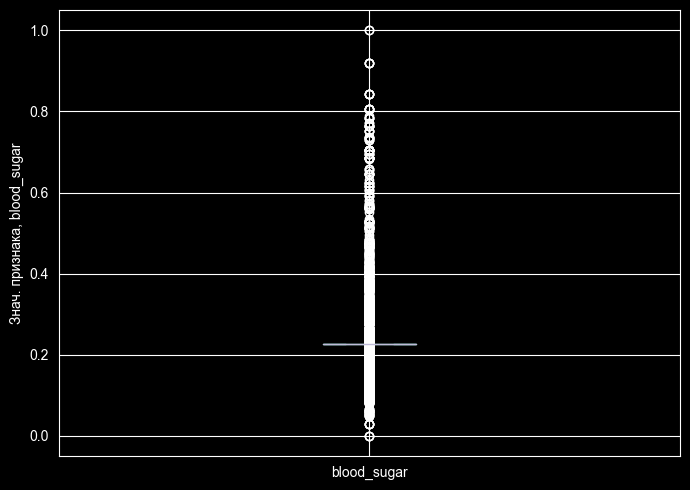

test


count    965.000000
mean       0.224207
std        0.065256
min        0.029644
25%        0.227018
50%        0.227018
75%        0.227018
max        0.750988
Name: blood_sugar, dtype: float64

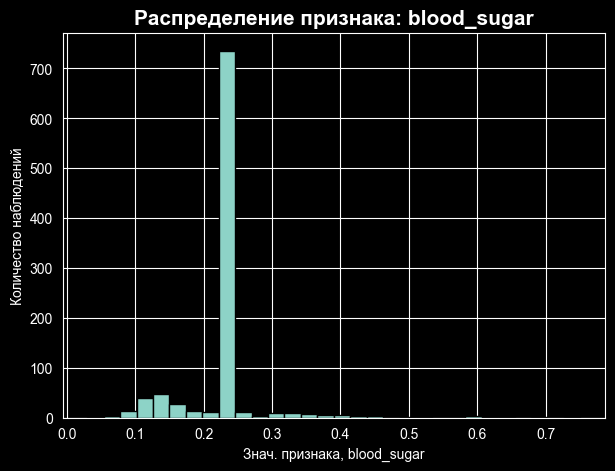

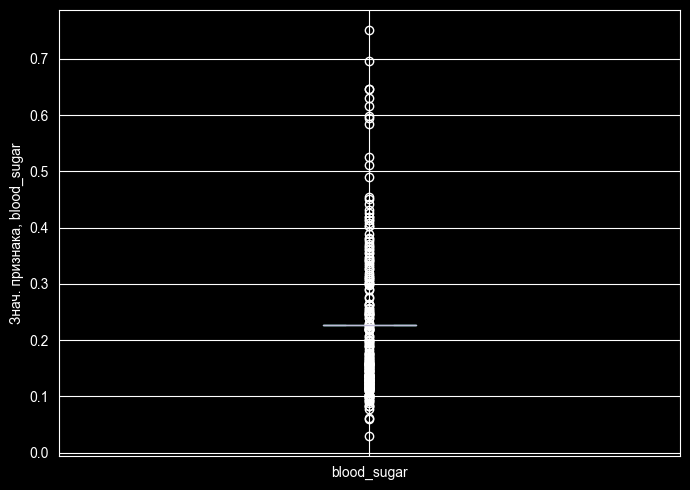

In [121]:
print('train')
numerical_visualise_histbox(X_train,'blood_sugar',30,'blood_sugar')
print('test')
numerical_visualise_histbox(X_test,'blood_sugar',30,'blood_sugar')
plt.show()

train


count    8683.000000
mean        0.048168
std         0.075537
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: ck-mb, dtype: float64

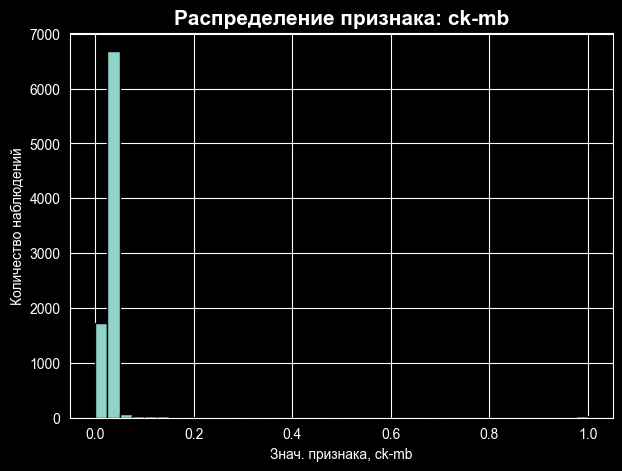

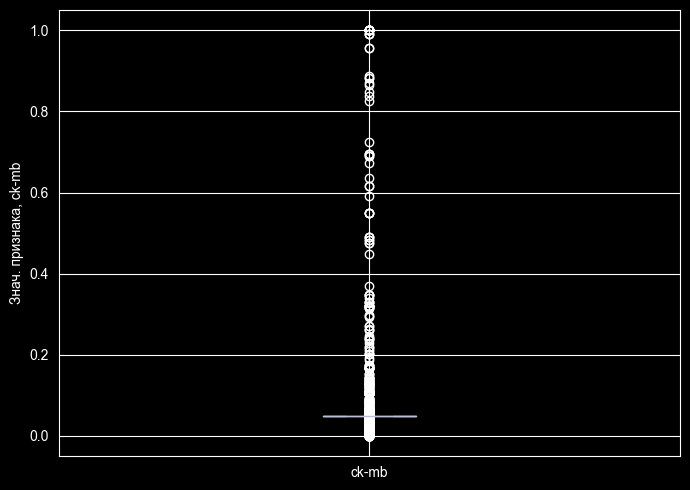

test


count    965.000000
mean       0.048902
std        0.079770
min        0.000000
25%        0.048229
50%        0.048229
75%        0.048229
max        1.000000
Name: ck-mb, dtype: float64

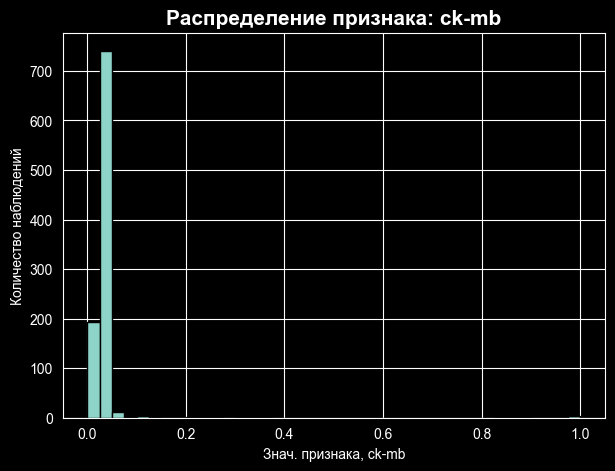

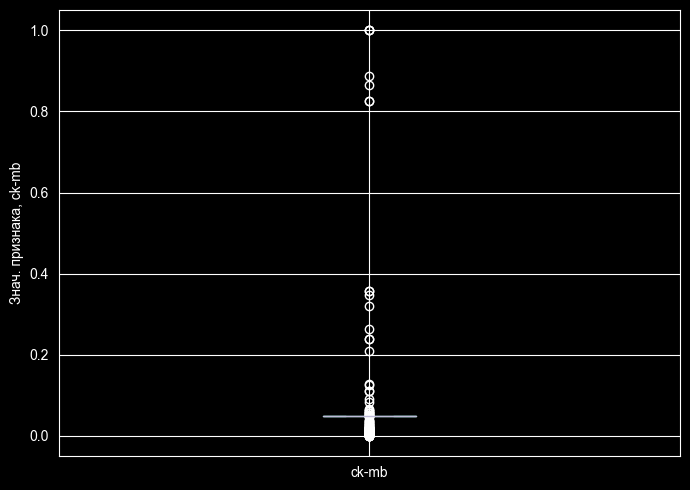

In [122]:
print('train')
numerical_visualise_histbox(X_train,'ck-mb',40,'ck-mb')
print('test')
numerical_visualise_histbox(X_test,'ck-mb',40,'ck-mb')
plt.show()

train


count    8683.000000
mean        0.036697
std         0.060161
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: troponin, dtype: float64

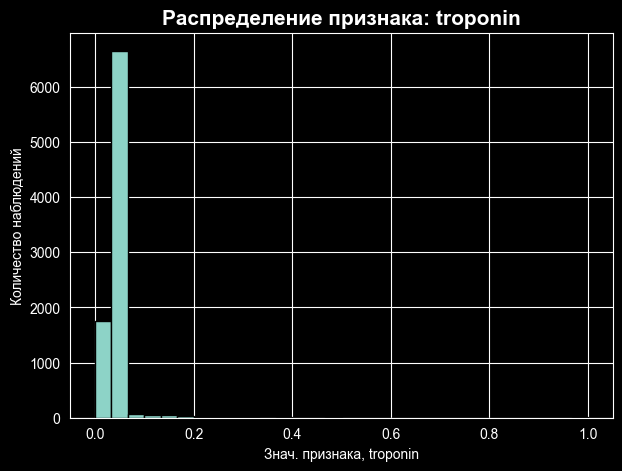

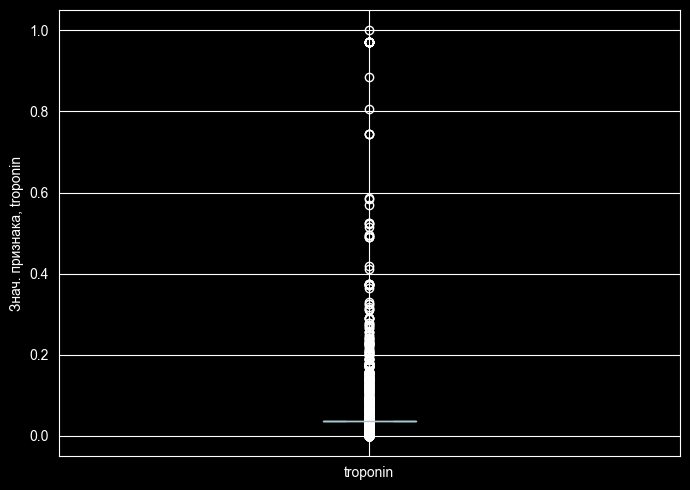

test


count    965.000000
mean       0.034861
std        0.053844
min        0.000194
25%        0.036512
50%        0.036512
75%        0.036512
max        0.970871
Name: troponin, dtype: float64

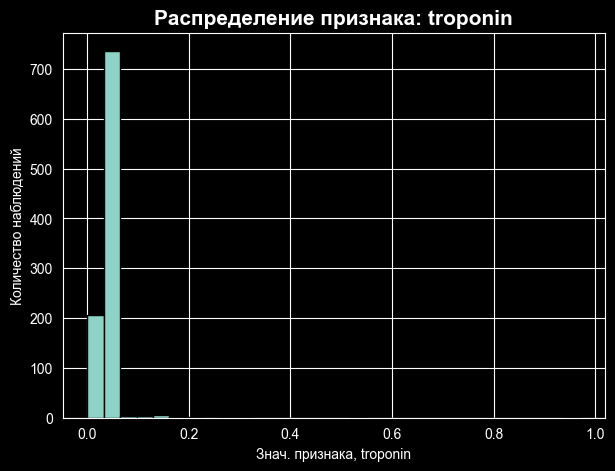

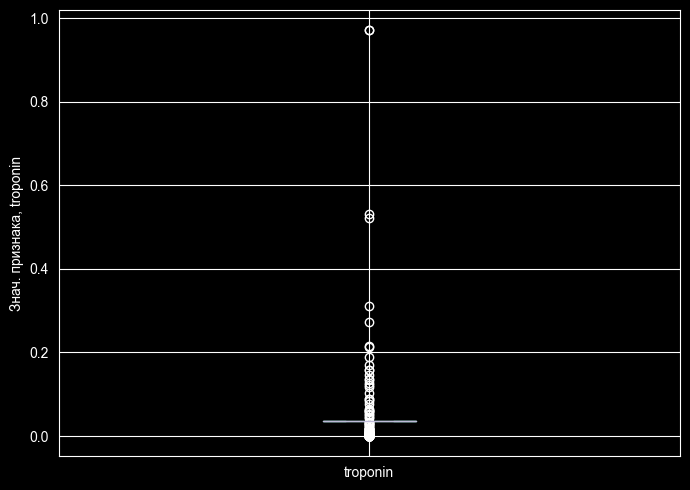

In [123]:
print('train')
numerical_visualise_histbox(X_train,'troponin',30,'troponin')
print('test')
numerical_visualise_histbox(X_test,'troponin',30,'troponin')
plt.show()

train
count     8683
unique       3
top       male
freq      5882
Name: gender, dtype: object


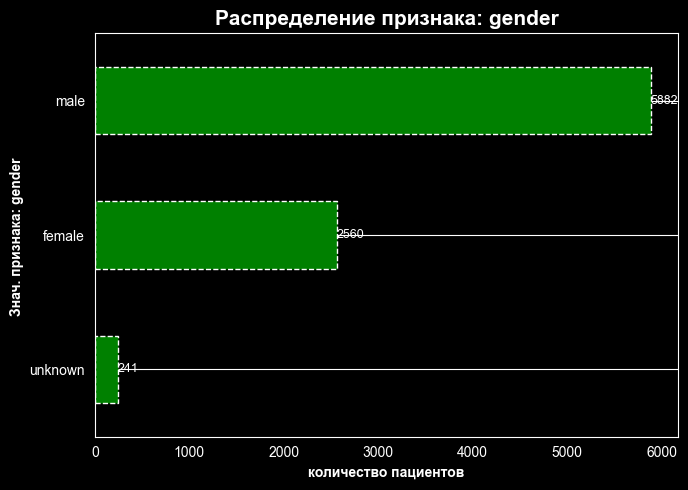

test
count      965
unique       3
top       male
freq       650
Name: gender, dtype: object


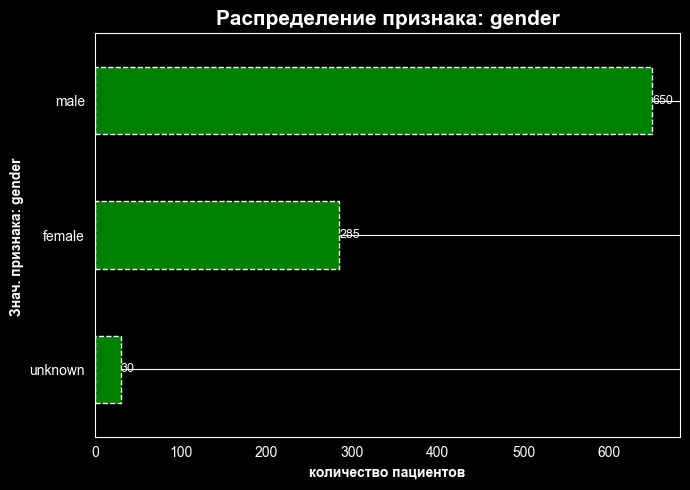

In [124]:
print('train')
barh_plot(X_train, 'gender', 'id', 'количество пациентов','')
print('test')
barh_plot(X_test, 'gender', 'id', 'количество пациентов','')
plt.show()

train


count    8683.000000
mean        0.450286
std         0.170203
min         0.000000
25%         0.303226
50%         0.445161
75%         0.600000
max         1.000000
Name: systolic_blood_pressure, dtype: float64

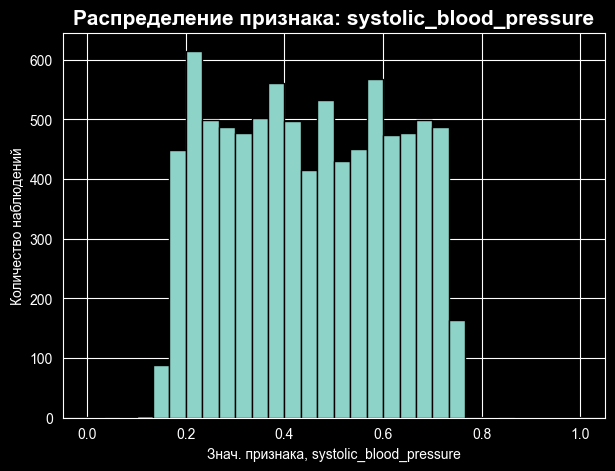

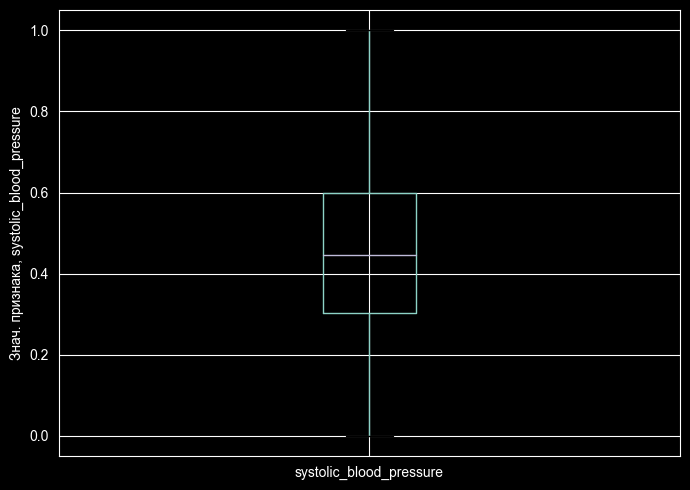

test


count    965.000000
mean       0.447127
std        0.171921
min        0.012903
25%        0.296774
50%        0.445161
75%        0.600000
max        0.741935
Name: systolic_blood_pressure, dtype: float64

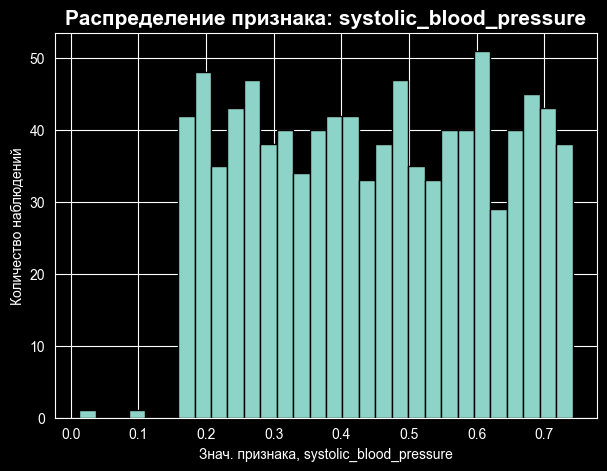

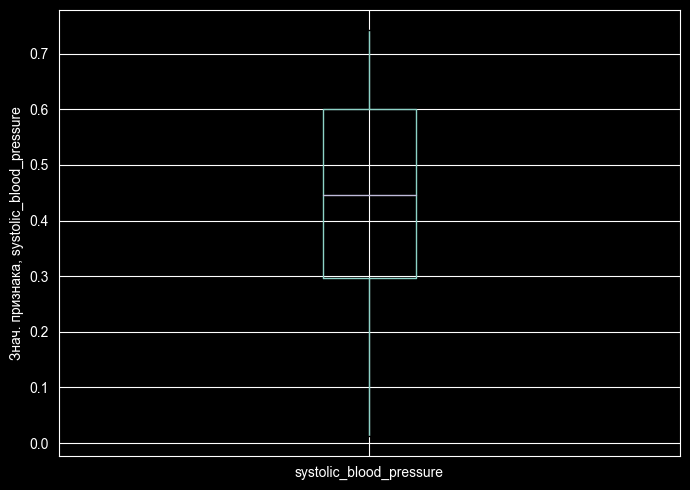

In [125]:
print('train')
numerical_visualise_histbox(X_train,'systolic_blood_pressure',30,'systolic_blood_pressure')
print('test')
numerical_visualise_histbox(X_test,'systolic_blood_pressure',30,'systolic_blood_pressure')
plt.show()

train


count    8683.000000
mean        0.497607
std         0.171841
min         0.000000
25%         0.348837
50%         0.500000
75%         0.651163
max         1.000000
Name: diastolic_blood_pressure, dtype: float64

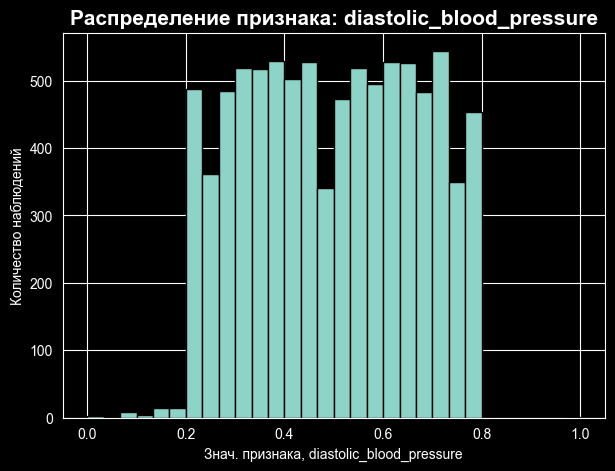

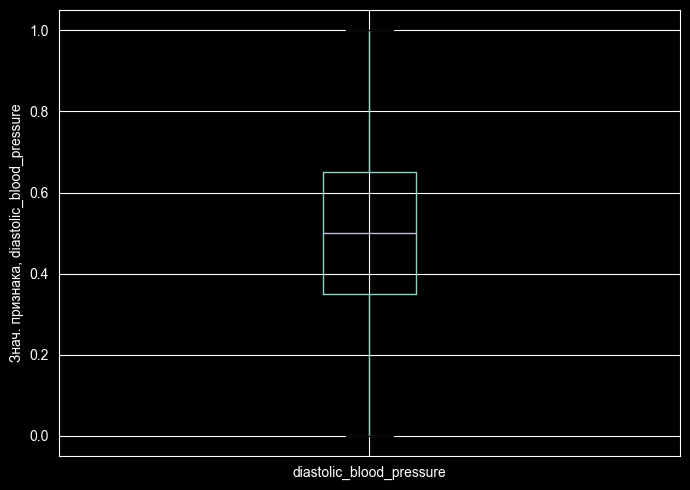

test


count    965.000000
mean       0.496698
std        0.173982
min        0.116279
25%        0.348837
50%        0.488372
75%        0.639535
max        0.790698
Name: diastolic_blood_pressure, dtype: float64

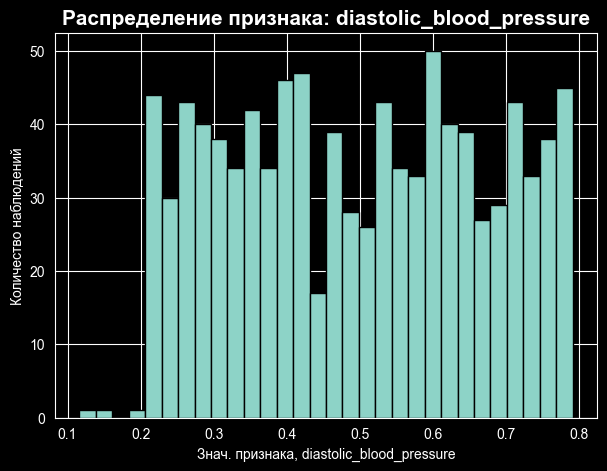

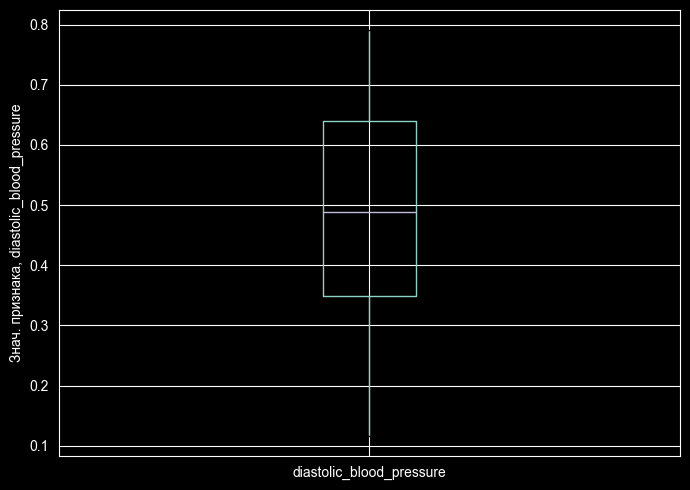

In [126]:
print('train')
numerical_visualise_histbox(X_train,'diastolic_blood_pressure',30,'diastolic_blood_pressure')
print('test')
numerical_visualise_histbox(X_test,'diastolic_blood_pressure',30,'diastolic_blood_pressure')
plt.show()

### Выводы по исследовательскому анализу данных

1. Все данные отмасштабированы в тестовой и тренировочной выборках.
2. Удалены 2 записи из тренировочного и 1 одна запись из тестового даасета, так как обнаружены явные выбросы в столбце heart rate
3. По диаграмме целевого признака heart_attak_risk, видно что имеется силный дисбаланс классов 65,3% (0) к 34,7% (1)
4. Другие явные выбросы или аномальные значения, которые можно бы было обработать обнаружены не были.

## Корреляционный анализ данных, анализ утечки целевого признака

In [127]:
def corr_phik_matrix(data,interval_cols):
    #  Строим phik_matrix для тренировочных данных 
    phik_corr = data.phik_matrix(interval_cols=interval_cols, verbose=False)
    
    # Создаем тепловую карту
    plt.figure(figsize=(15, 10))
    sns.heatmap(phik_corr, 
                annot=True, 
                cmap='coolwarm', 
                linewidths=1, 
                linecolor='blue',
                square=False, 
                fmt='.2f')
    
    plt.title("Phik correlation matrix", pad=10, fontsize=14)
    plt.xticks(rotation=45, ha='right')  
    plt.yticks(rotation=0)  
    plt.tight_layout() 
    return plt.show()

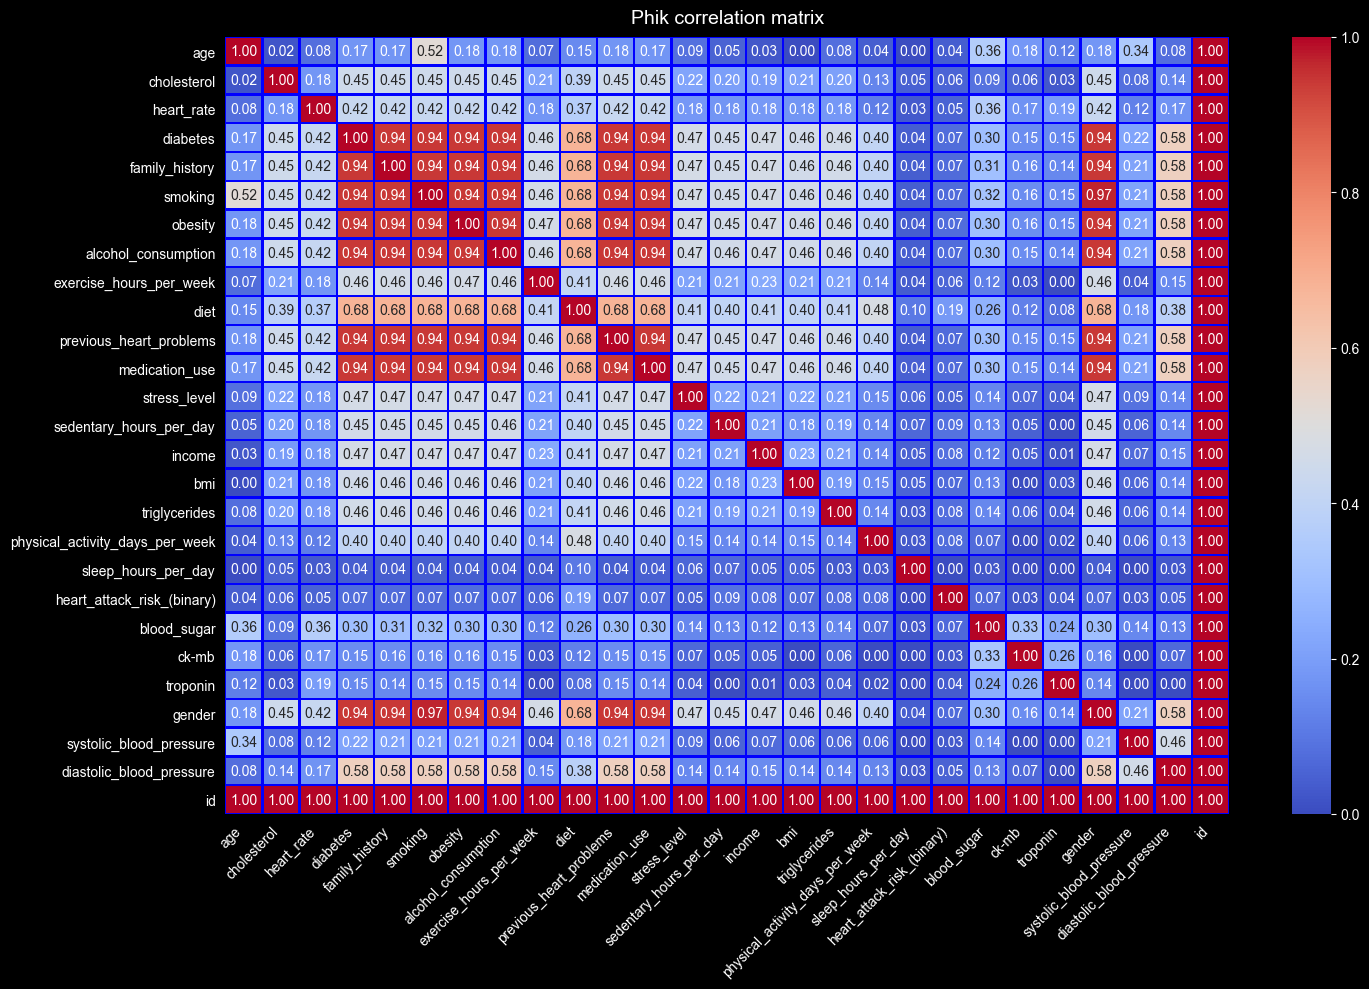

In [128]:
interval_cols= ['age',
                   'cholesterol', 
                   'heart_rate',
                   'exercise_hours_per_week',
                   'sedentary_hours_per_day',
                   'income',
                   'bmi',
                   'triglycerides',
                   'blood_sugar',
                   'ck-mb',
                   'troponin',
                   'systolic_blood_pressure',
                   'diastolic_blood_pressure']
corr_phik_matrix(X_train,interval_cols)

В тренировочных данных наблюдаем что, признаки diabetes, family_history,smoking,obesity,alcohol_consumption, previous_heart_problems, medication_use,gender сильно скоррелированы между собой. Попробуем обединить их в один признак survey_risk_score. Также достаточно сильно скоррелированы признаки 'sleep_hours_per_day', 'diet', 'gender'.

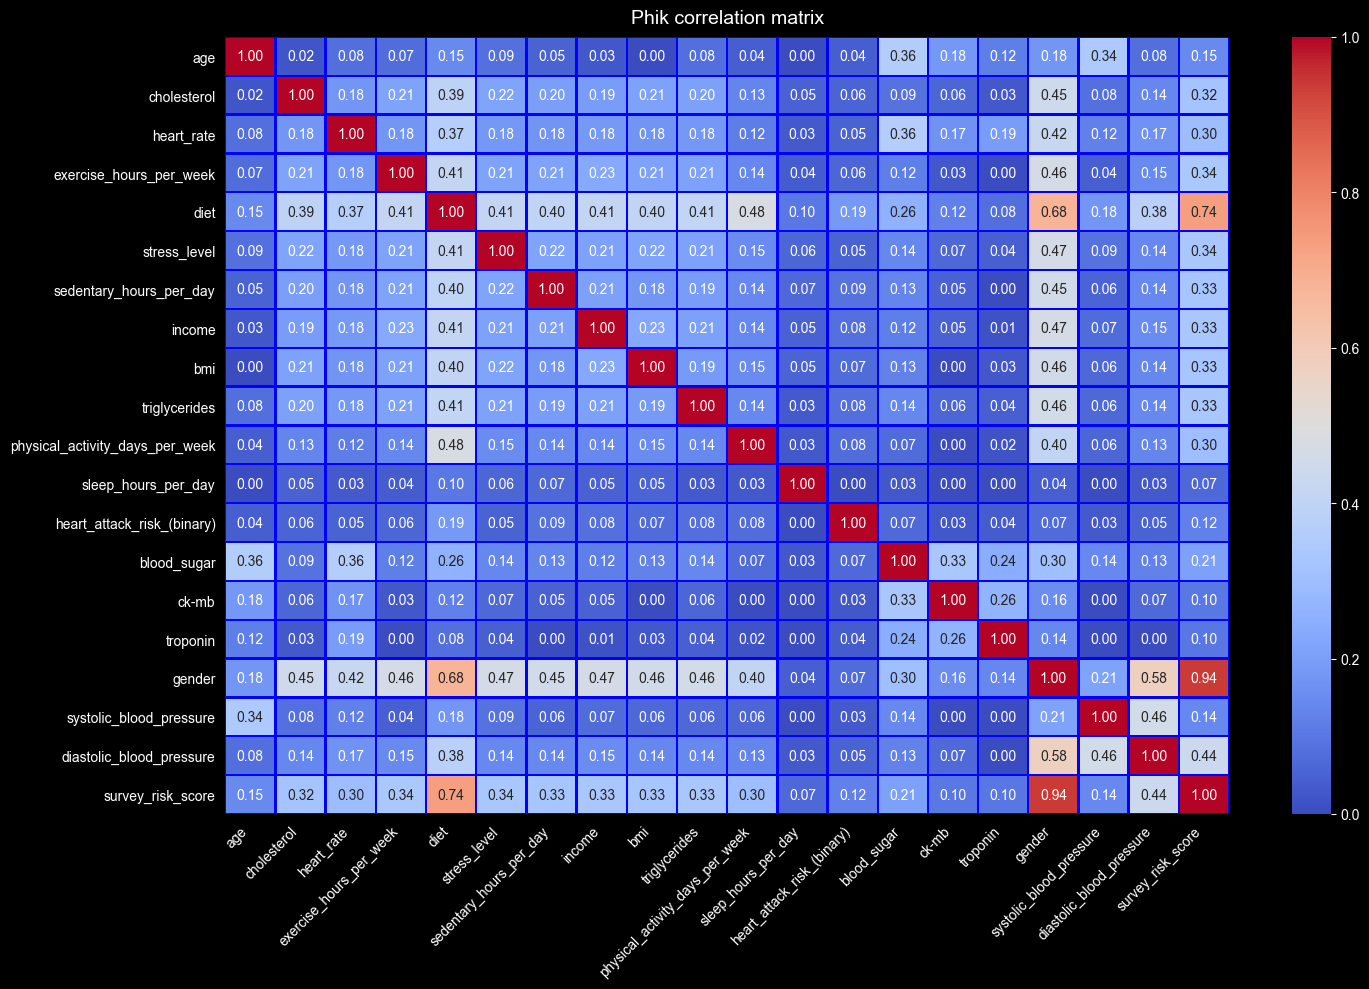

In [129]:
#объединяем, исключаем признаки
X_train['survey_risk_score'] = X_train[binary_cols].sum(axis=1).astype('int')
X_train=X_train.drop(['id','diabetes', 'family_history', 'smoking', 'obesity', 
               'alcohol_consumption', 'previous_heart_problems', 'medication_use'],axis=1)

# строим матрицу
interval_cols= ['age',
                   'cholesterol', 
                   'heart_rate',
                   'exercise_hours_per_week',
                   'sedentary_hours_per_day',
                   'income',
                   'bmi',
                   'triglycerides',
                   'blood_sugar',
                   'ck-mb',
                   'troponin',
                   'systolic_blood_pressure',
                   'diastolic_blood_pressure']
corr_phik_matrix(X_train,interval_cols)

- Общая картина уже лучше, однако, видим, что наблюдается корреляция между diet и sleep_hours_per_day корреляция 0.89, а между sleep_hours_per_day и gender 0.79 и при этом с сагрегированным признаком survey_risk_score у них корреляция у каждого также достаточно высока. Следует вывод, что мультиколлинеарность высока и эти анкетные данные могут быть определены через сагрегированный признак. Исключим gender из датасета и оценим корреляцию еще раз.
- Наличие troponin или ck-mb фактически напрямую свидетельствуют об утечке целевого признака, так как наличие этих маркеров в анализе крови свидетельствуют об инфаркте. Эти данные необходимо исключить из входных признаков.

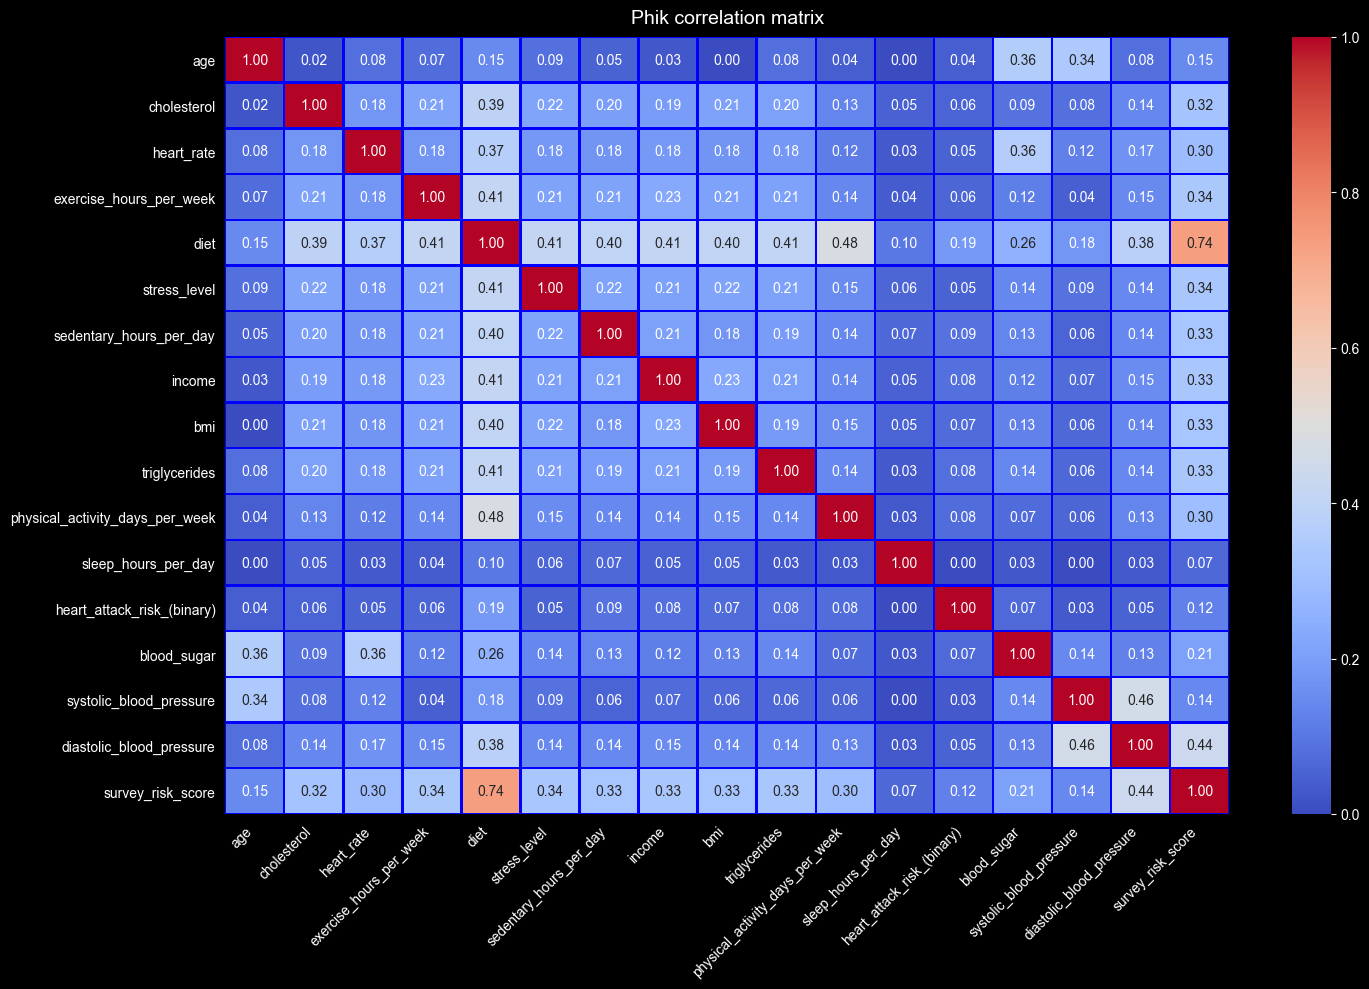

In [130]:
X_train=X_train.drop(['gender', 'troponin','ck-mb'],axis=1)
interval_cols= ['age',
                   'cholesterol', 
                   'heart_rate',
                   'exercise_hours_per_week',
                   'sedentary_hours_per_day',
                   'income',
                   'bmi',
                   'triglycerides',
                   'blood_sugar',
                   'systolic_blood_pressure',
                   'diastolic_blood_pressure']
corr_phik_matrix(X_train,interval_cols)

По полученным данным можно утверждать, что утечка целевого признака и мультиколлинеарность отсутствуют. Теперь по аналогии преобразуем тестовый набор данных и приступим к обучению модели.

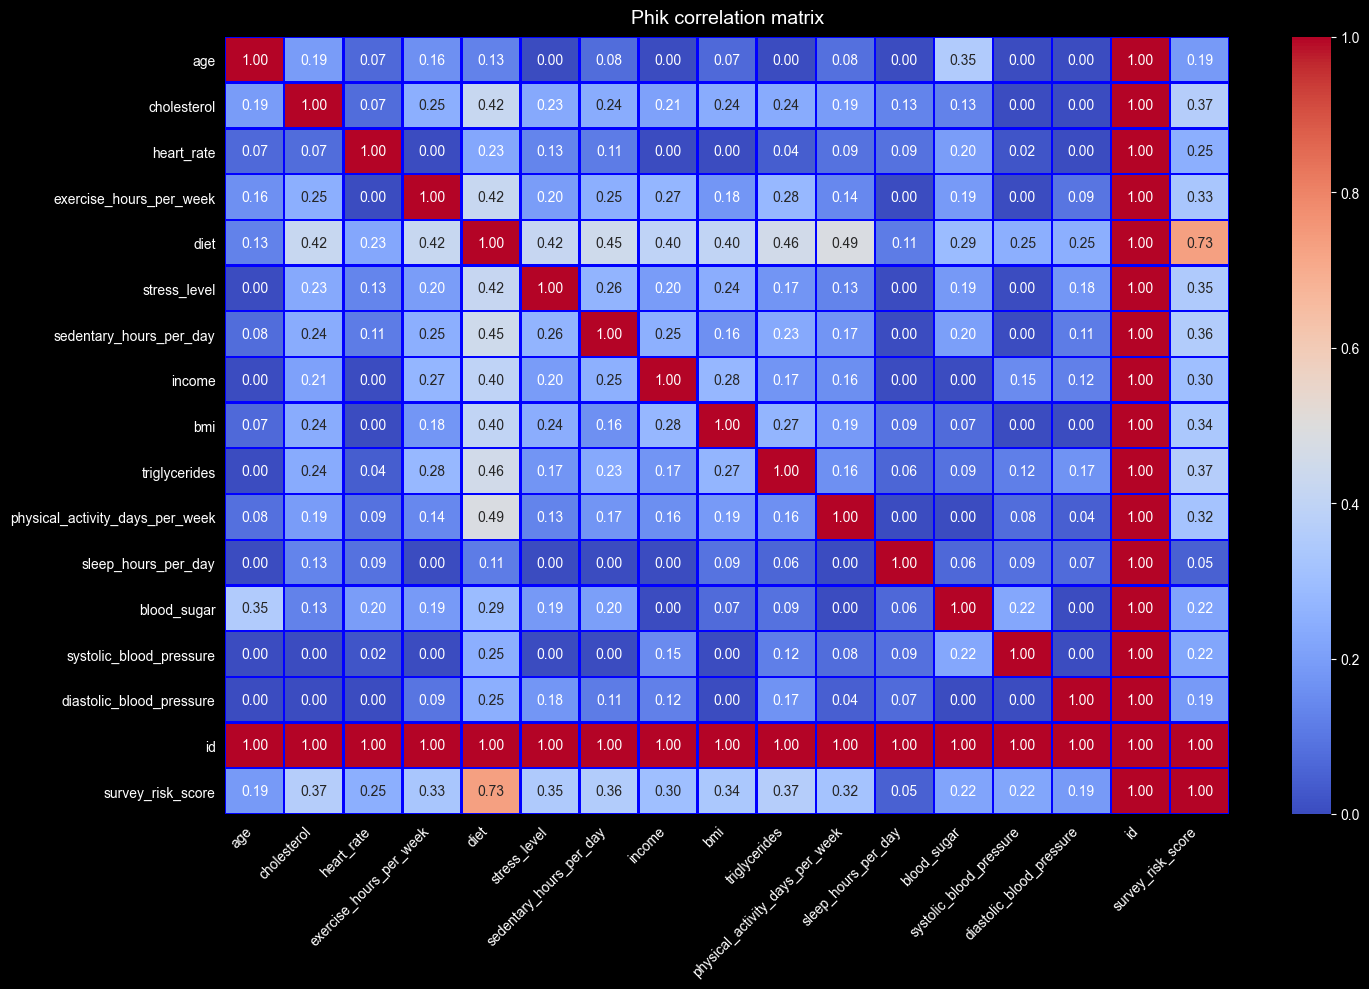

In [131]:
X_test['survey_risk_score'] = X_test[binary_cols].sum(axis=1).astype('int')
X_test=X_test.drop(['diabetes', 'family_history', 'smoking', 'obesity', 
               'alcohol_consumption', 'previous_heart_problems', 'medication_use','gender','troponin','ck-mb'],axis=1)

test_id=X_test['id']
interval_cols= ['age',
                   'cholesterol', 
                   'heart_rate',
                   'exercise_hours_per_week',
                   'sedentary_hours_per_day',
                   'income',
                   'bmi',
                   'triglycerides',
                   'blood_sugar',
                   'systolic_blood_pressure',
                   'diastolic_blood_pressure']
corr_phik_matrix(X_test,interval_cols)

## Оценка дисбаланса классов

In [132]:
X_train['heart_attack_risk_(binary)'].value_counts()

0    5670
1    3013
Name: heart_attack_risk_(binary), dtype: int64

count    8683.000000
mean        0.347000
std         0.476043
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: heart_attack_risk_(binary), dtype: float64


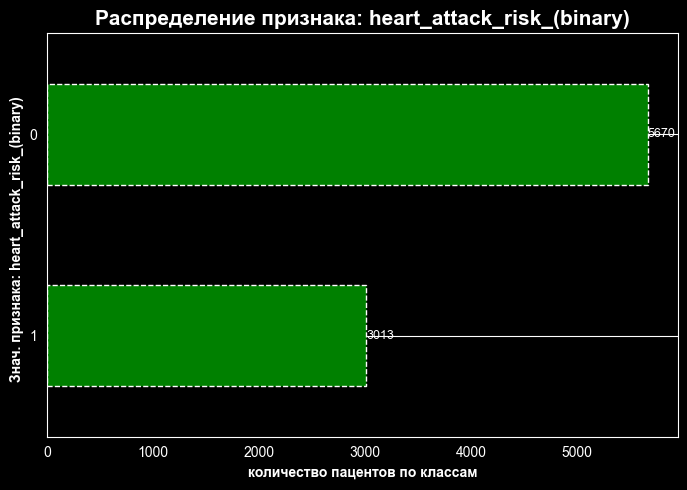

In [133]:
barh_plot(X_train, 'heart_attack_risk_(binary)', 'age', 'количество пацентов по классам',' ')


Так как наблюдается умеренный дисбалас классов примерно 65 на 35, то будем использовать веса при обучении модели.

## Обучение модели

По итогам предобработки и анализа данных у нас есть:
- 5 категориальных признака(тип int):
    - 'survey_risk_score',
    - 'stress_level',
    - 'physical_activity_days_per_week',
    - 'sleep_hours_per_day',
    - 'survey_risk_score'
    - diet
- 11 числовых(тип float):
    -  'age',
    -  'cholesterol',
    -  'heart_rate',
    -  'exercise_hours_per_week',
    -  'sedentary_hours_per_day',
    -  'income',
    -  'bmi',
    -  'triglycerides',
    -  'blood_sugar',
    -  'systolic_blood_pressure',
    -  'diastolic_blood_pressure'.
- 1 целевой признак 'heart_attack_risk_(binary)


In [134]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8683 entries, 0 to 8684
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8683 non-null   float64
 1   cholesterol                      8683 non-null   float64
 2   heart_rate                       8683 non-null   float64
 3   exercise_hours_per_week          8683 non-null   float64
 4   diet                             8683 non-null   int64  
 5   stress_level                     8683 non-null   int32  
 6   sedentary_hours_per_day          8683 non-null   float64
 7   income                           8683 non-null   float64
 8   bmi                              8683 non-null   float64
 9   triglycerides                    8683 non-null   float64
 10  physical_activity_days_per_week  8683 non-null   int32  
 11  sleep_hours_per_day              8683 non-null   int32  
 12  heart_attack_risk_(b

In [135]:
X_train['sleep_hours_per_day'].unique()

array([0, 1])

In [136]:

cat_features = [
    'stress_level',
    'physical_activity_days_per_week',
    'survey_risk_score',
    'sleep_hours_per_day',
    'diet'
]

num_features = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'blood_sugar',
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
]
y_train=X_train['heart_attack_risk_(binary)']

In [137]:
# Подготовка данных
X = X_train[cat_features + num_features]
y = X_train['heart_attack_risk_(binary)']

# Параметры
params = dict(
    loss_function="Logloss",
    eval_metric="AUC",
    learning_rate=0.03,
    depth=6,
    iterations=5000,
    random_seed=42,
    verbose=0,
    auto_class_weights="Balanced"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_auc = 0
aucs = []
for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    model = CatBoostClassifier(**params)
    model.fit(
        X_tr, y_tr,
        cat_features=cat_features,
        eval_set=(X_va, y_va),
        use_best_model=True,
        early_stopping_rounds=200
    )

    p = model.predict_proba(X_va)[:, 1]
    auc = roc_auc_score(y_va, p)
    aucs.append(auc)
    print(f"Фолд {fold}: ROC-AUC = {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        model.save_model('best_overall_model.cbm')
        print(f"--> Новая лучшая модель найдена на фолде {fold} (AUC: {auc:.4f})")

print(f"\nСредний ROC-AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

Фолд 1: ROC-AUC = 0.6092
--> Новая лучшая модель найдена на фолде 1 (AUC: 0.6092)
Фолд 2: ROC-AUC = 0.5648
Фолд 3: ROC-AUC = 0.6098
--> Новая лучшая модель найдена на фолде 3 (AUC: 0.6098)
Фолд 4: ROC-AUC = 0.5423
Фолд 5: ROC-AUC = 0.5470

Средний ROC-AUC: 0.5746 ± 0.0294


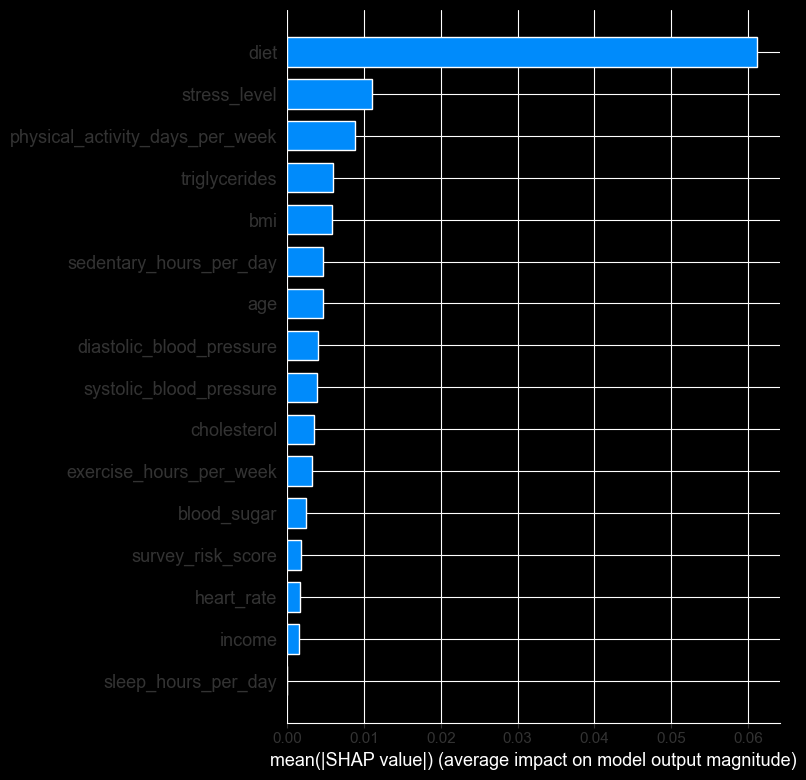

In [138]:

# 1) делаем Pool (ВАЖНО: передаём cat_features)
pool = Pool(X, y, cat_features=cat_features)

# 2) считаем SHAP
shap_values = model.get_feature_importance(
    pool,
    type="ShapValues"
)

# 3) убираем последний столбец (bias)
shap_values = shap_values[:, :-1]

# 4) summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

In [139]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Bord

In [140]:
#сохраняем лучшую модель
# текущая папка (где лежит ноутбук)
current_dir = Path.cwd()

# корень проекта = папка уровнем выше notebooks
project_root = current_dir.parent

# папка models в корне проекта
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

# сохраняем модель
model_path = models_dir / "model.pkl"
joblib.dump(model, model_path)

print(f"Saved to {model_path}")

Saved to C:\Users\taran\heart_attack_project\models\model.pkl


In [144]:
#получаем предсказания на тестовой выборке и сохраняем в csv
X_test = X_test[['stress_level',
    'physical_activity_days_per_week',
    'survey_risk_score',
    'sleep_hours_per_day',
    'diet',
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'blood_sugar',
    'systolic_blood_pressure',
    'diastolic_blood_pressure']]

# вероятность положительного класса
y_proba = model.predict_proba(X_test)[:, 1]

# бинарные предсказания (0/1)
y_pred = (y_proba >= 0.5).astype(int)

submission = pd.DataFrame({
    "id": test_id.values,
    "prediction": y_pred
})

submission.to_csv("submission.csv", index=False)
submission["prediction"].value_counts()

1    778
0    187
Name: prediction, dtype: int64

## Выводы
1. Предобработаны тестовые и тренировочные данные (объеденены анкетные данные в единый входной признак, изменены типы данных, устранены выбросы, определены категориальные и числовые признаки.
2. Проведен корреляционный анализ данных, устранена мультиколлинеарность.
3. Устранена утечка целевого признака.
3. Проведена оценка дисбаланса классов.
4. Обучена модель CatBoostClassifier.Лучшая модель найдена на фолде 3 (AUC: 0.6098) со следующими параметрами:


{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 200,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'ctr_target_border_count': 1,
 'posterior_sampling': False,
 'has_time': False,
 'store_all_simple_ctr': False,
 'border_count': 254,
 'class_weights': [1, 1.8813769817352295],
 'classes_count': 0,
 'auto_class_weights': 'Balanced',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.029999999329447743,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 10,
 'bootstrap_type': 'MVS',
 'max_leaves': 64,
 'permutation_count': 4}



5. Получены предсказания на тестовой выборке и сохранены в scv файл.